In [11]:
import pandas as pd
import yfinance as yf
import itertools
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import seaborn as sns
from statsmodels.distributions.empirical_distribution import ECDF

def scatterplot_matrix(data, names, **kwargs):
    """Plots a scatterplot matrix of subplots.  Each row of "data" is plotted
    against other rows, resulting in a nrows by nrows grid of subplots with the
    diagonal subplots labeled with "names".  Additional keyword arguments are
    passed on to matplotlib's "plot" command. Returns the matplotlib figure
    object containg the subplot grid."""
    numvars, numdata = data.shape
    fig, axes = plt.subplots(nrows=numdata, ncols=numdata, figsize=(15,15))
    fig.subplots_adjust(hspace=0.05, wspace=0.05)

    for ax in axes.flat:
        # Hide all ticks and labels
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

        # Set up ticks only on one side for the "edge" subplots...
        if ax.is_first_col():
            ax.yaxis.set_ticks_position('left')
        if ax.is_last_col():
            ax.yaxis.set_ticks_position('right')
        if ax.is_first_row():
            ax.xaxis.set_ticks_position('top')
        if ax.is_last_row():
            ax.xaxis.set_ticks_position('bottom')

    # Plot the data.
    for i, j in zip(*np.triu_indices_from(axes, k=1)):
        for x, y in [(i,j), (j,i)]:
            axes[x,y].plot(data.iloc[:,x], data.iloc[:,y], **kwargs)

    # Label the diagonal subplots...
    for i, label in enumerate(names):
        axes[i,i].annotate(label, (0.5, 0.5), xycoords='axes fraction',
                ha='center', va='center')

    # Turn on the proper x or y axes ticks.
    # for i, j in zip(range(numdata), itertools.cycle((-1, 0))):
    #     print(i, j)
    #     axes[j,i].xaxis.set_visible(True)
    #     axes[i,j].yaxis.set_visible(True)

    return fig   


## Theory and intuition about copulas can be found in Attilio's Meucci paper ["A short, comprehensive, practical guide to copulas"](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=1847864)

[*********************100%***********************]  5 of 5 completed


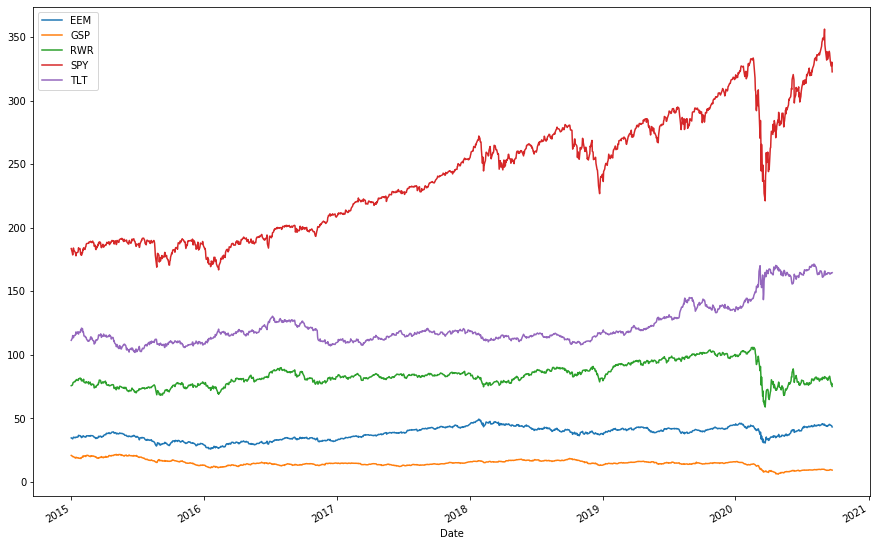

In [12]:
# SPY: S&P
# EEM: Emerging markets basket
# TLT: 20+ year treasury bond
# GSP: S&P GSCI (commodities market)
# RWR: Dow Jones REITs (real state)

tickers_list = ['SPY', 'EEM', 'TLT', 'GSP', 'RWR']
df = yf.download(tickers_list,'2015-1-1')['Adj Close']
df.plot(figsize=(15,10))

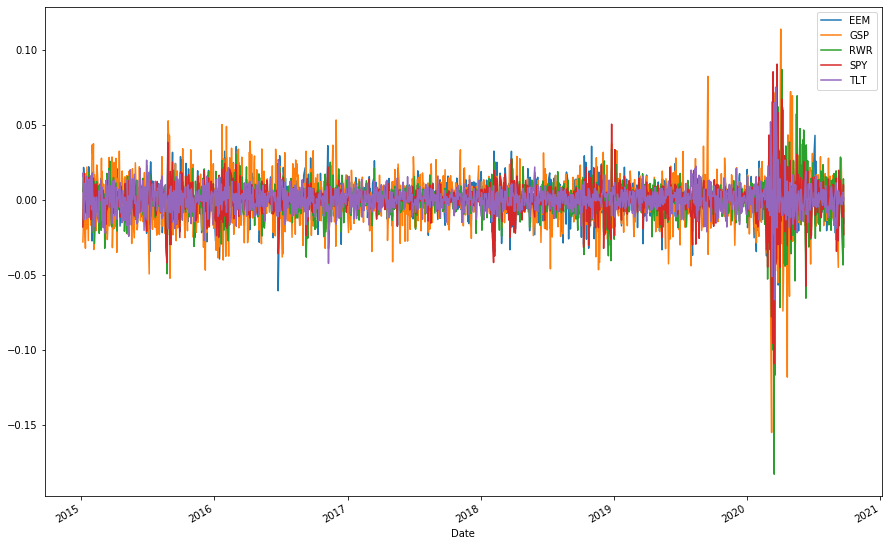

In [13]:
daily_returns_df = df.pct_change(1).dropna()
daily_returns_df.plot(figsize=(15,10))

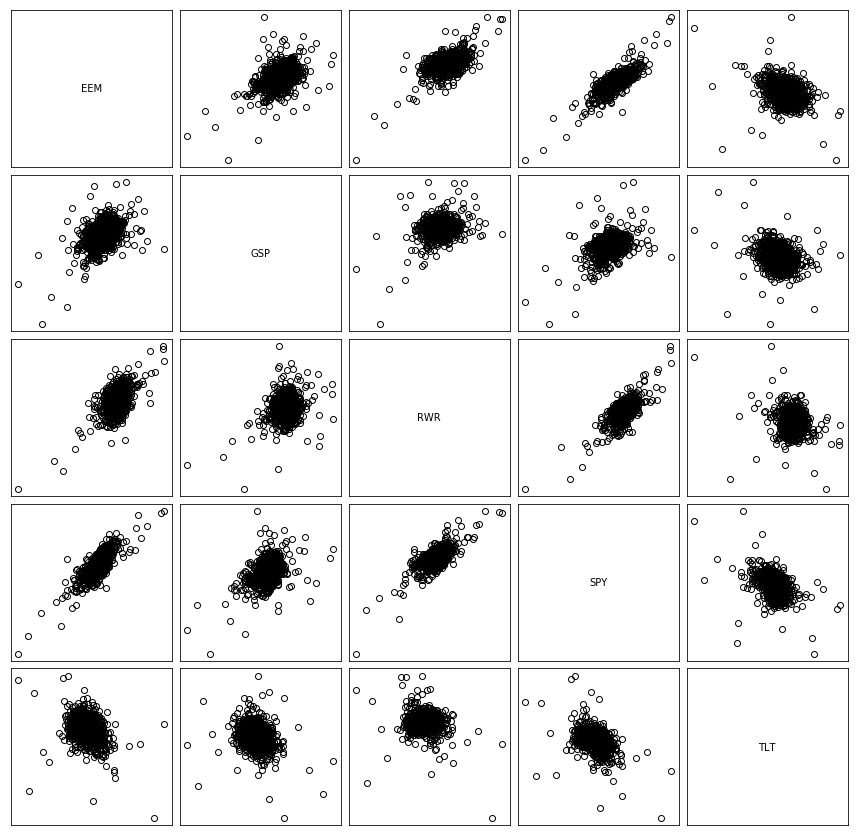

In [14]:
fig = scatterplot_matrix(daily_returns_df, list(daily_returns_df.columns), linestyle='none', marker='o', color='black', mfc='none')
# fig.suptitle('Simple Scatterplot Matrix')

## 1. Example with known multivariate normal distribution

In [15]:
mvnorm = st.multivariate_normal(mean=[0, 0], cov=[[1., 0.5], 
                                                     [0.5, 1.]])
x = mvnorm.rvs(10000)

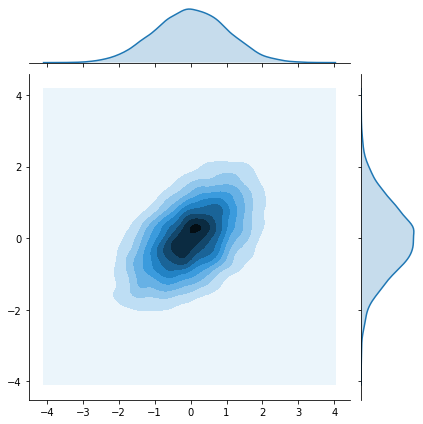

In [16]:
sns.jointplot(x[:, 0], x[:, 1], kind='kde', stat_func=None)

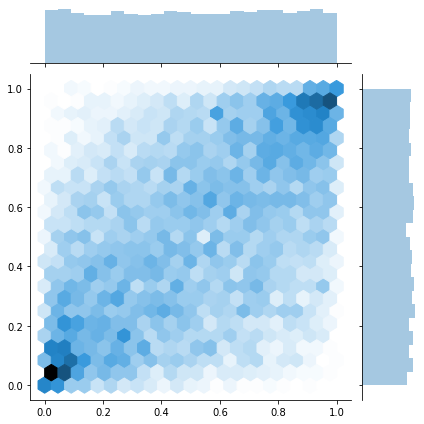

In [17]:
x_unif = st.norm.cdf(x)
sns.jointplot(x_unif[:, 0], x_unif[:, 1], kind='hex', stat_func=None)

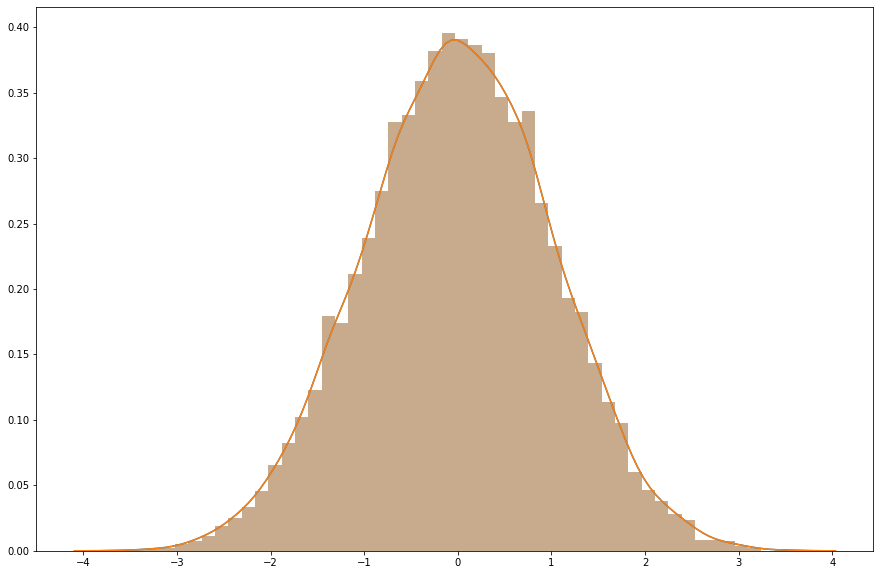

In [18]:
fig, ax = plt.subplots(figsize=(15,10))
sns.distplot(st.norm.ppf(x_unif[:,0]), ax=ax)
sns.distplot(x[:, 0], ax=ax)

### Fitting a gaussian copula

In [19]:
from copulas.multivariate import GaussianMultivariate

copula = GaussianMultivariate()
copula.fit(x)

C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


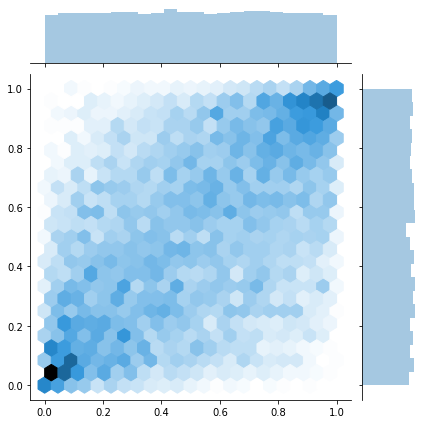

In [20]:
x1 = copula.univariates[0].cdf(x[:,0])
x2 = copula.univariates[1].cdf(x[:,1])
sns.jointplot(x1, x2, kind='hex', stat_func=None)

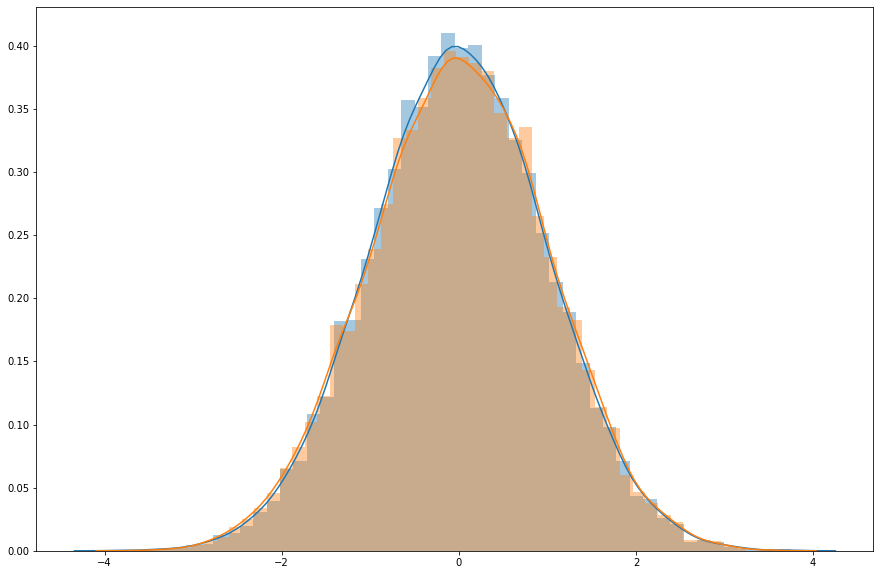

In [21]:
fig, ax = plt.subplots(figsize=(15,10))
sns.distplot(st.norm.ppf(x1), ax=ax)
sns.distplot(x[:, 0], ax=ax)

## 2. Real data experiment using [Copulas](https://sdv.dev/Copulas/index.html) package

In [22]:
copula = GaussianMultivariate()
copula.fit(daily_returns_df)

marginal_cdfs = {}
for i, j in enumerate(daily_returns_df.columns):
    marginal = copula.univariates[i].cdf(daily_returns_df.iloc[:,i])
    marginal_cdfs[j] = marginal
marginal_cdfs_df = pd.DataFrame.from_dict(marginal_cdfs)
marginal_cdfs_df

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_continuous_distns.py:547: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\ProgramData\Anaconda3\lib\site-packages\copulas\univariate\truncated_gaussian.py:43: RuntimeWarning: divide by zero encountered in double_scalars
  a = (self.min - loc) / scale
C:\ProgramData\Anaconda3\lib\site-packages\copulas\univariate\truncated_gaussian.py:44: RuntimeWarning: divide by zero encountered in double_scalars
  b = (self.max - loc) / scale
C:\ProgramData\Anaconda3\lib\site-packages\copulas\univariate\truncated_gaussian.py:43: RuntimeWarning: invalid value encountered in double_scalars
  a = (self.min - loc) / scale


,EEM,GSP,RWR,SPY,TLT
0,0.067551,0.043174,0.708336,0.033628,0.968644
1,0.325637,0.089469,0.837376,0.094634,0.980223
2,0.949645,0.486486,0.922338,0.921115,0.373344
3,0.913118,0.611951,0.614325,0.958431,0.055482
4,0.355736,0.195394,0.535843,0.116869,0.913153
...,...,...,...,...,...
1436,0.332392,0.844936,0.072970,0.103756,0.635101
1437,0.221702,0.742155,0.025990,0.070810,0.322151
1438,0.188698,0.025408,0.006771,0.074512,0.733268
1439,0.229782,0.401552,0.904544,0.890398,0.430498


In [23]:
copula.univariates[0].cdf(1)

0.9999999878730145

In [24]:
copula.covariance

array([[ 1.00046354,  0.42603333,  0.45010888,  0.77158249, -0.28776522],
       [ 0.42603333,  1.00052546,  0.16554252,  0.38963648, -0.24488008],
       [ 0.45010888,  0.16554252,  0.99941615,  0.59616015, -0.05193979],
       [ 0.77158249,  0.38963648,  0.59616015,  0.99947545, -0.37792689],
       [-0.28776522, -0.24488008, -0.05193979, -0.37792689,  0.94306196]])

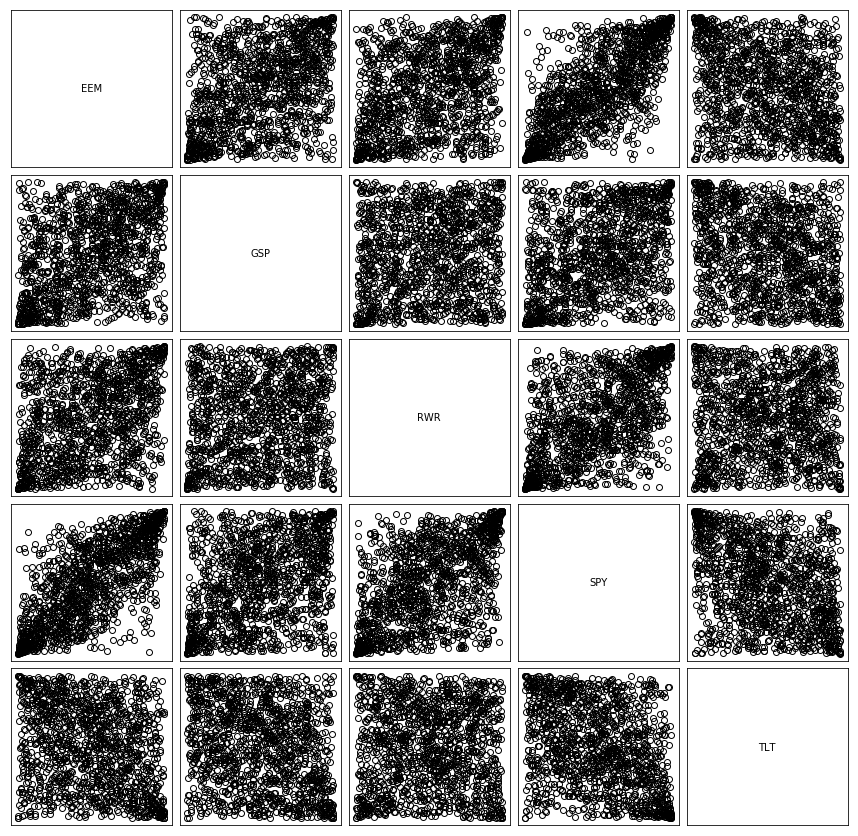

In [25]:
fig = scatterplot_matrix(marginal_cdfs_df, list(daily_returns_df.columns), linestyle='none', marker='o', color='black', mfc='none')

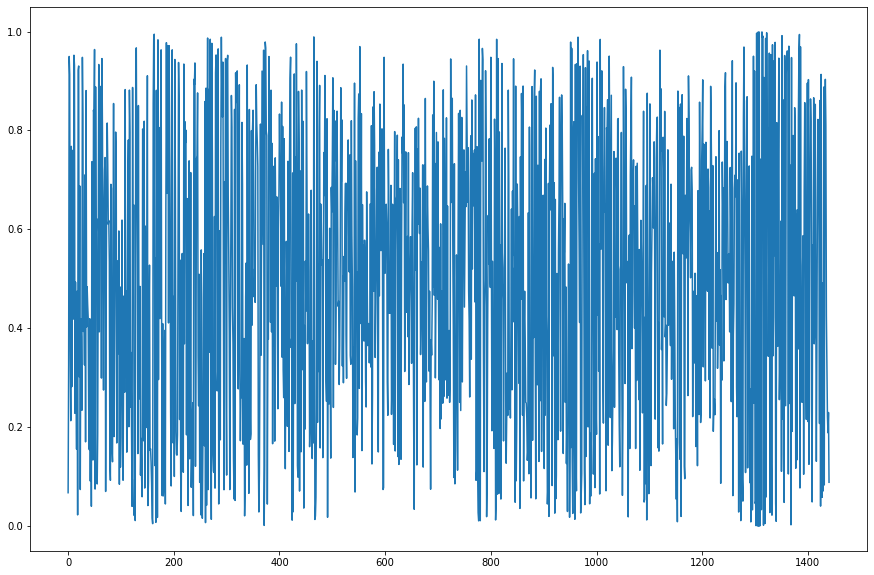

In [26]:
fig, ax = plt.subplots(figsize=(15,10))
sns.lineplot(data=marginal_cdfs_df.iloc[:,0], ax=ax)

In [27]:
st.norm.ppf(marginal_cdfs_df.iloc[:,0])

array([-1.49428168, -0.45199382,  1.6414227 , ..., -0.88270621,
       -0.73956531, -1.34915027])

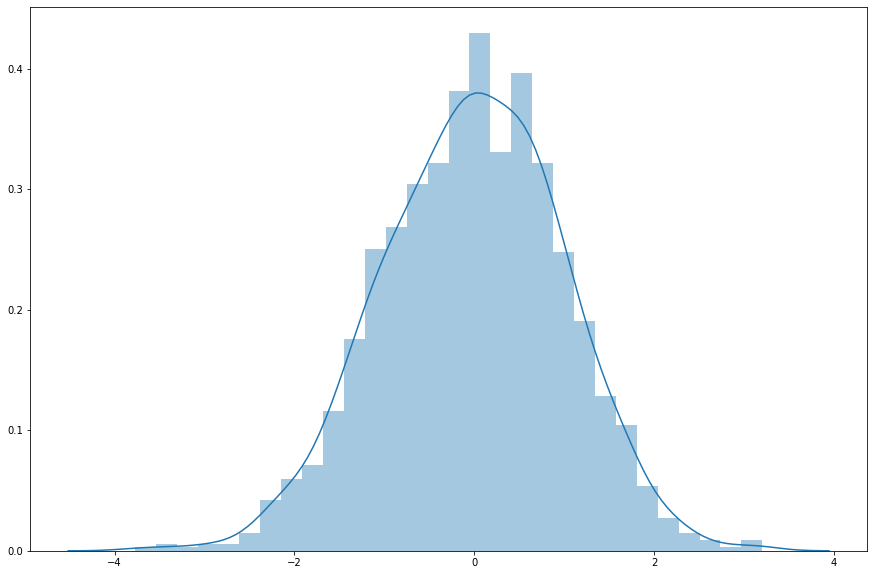

In [28]:
fig, ax = plt.subplots(figsize=(15,10))
sns.distplot(st.norm.ppf(marginal_cdfs_df.iloc[:,0]), ax=ax)

### Here i have assumed a Gaussian copula. Discussions on how to fit the best copula function to your marginals can be found [here](https://copulae.readthedocs.io/en/latest/) and [here](http://www.deep-mind.org/2017/09/24/empirical_copula/)

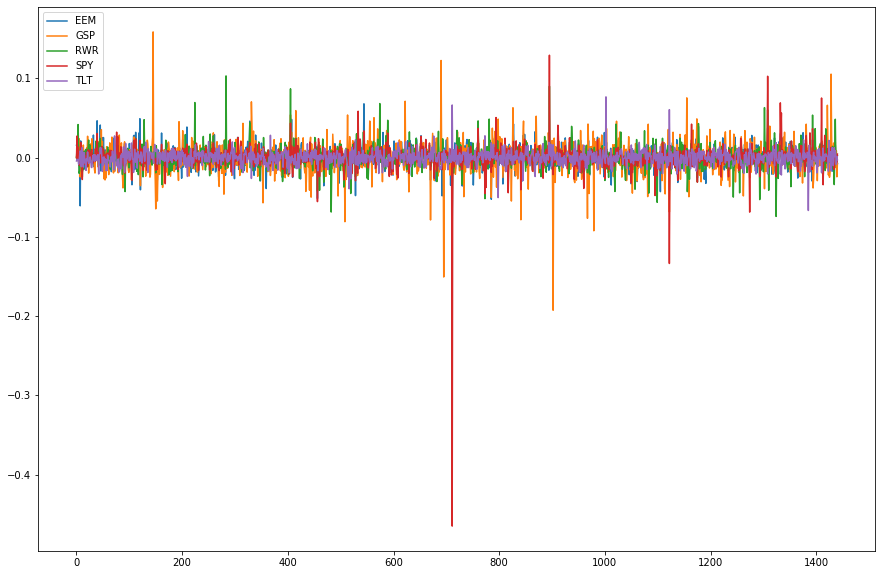

In [29]:
synthetic = copula.sample(len(marginal_cdfs_df))
synthetic.plot(figsize=(15,10))

### Copula implied marginal vs empirical distribution

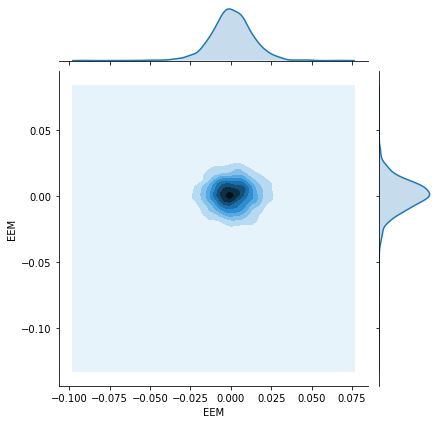

In [30]:
sns.jointplot(synthetic.iloc[:,0], daily_returns_df.iloc[:, 0], kind='kde', stat_func=None)

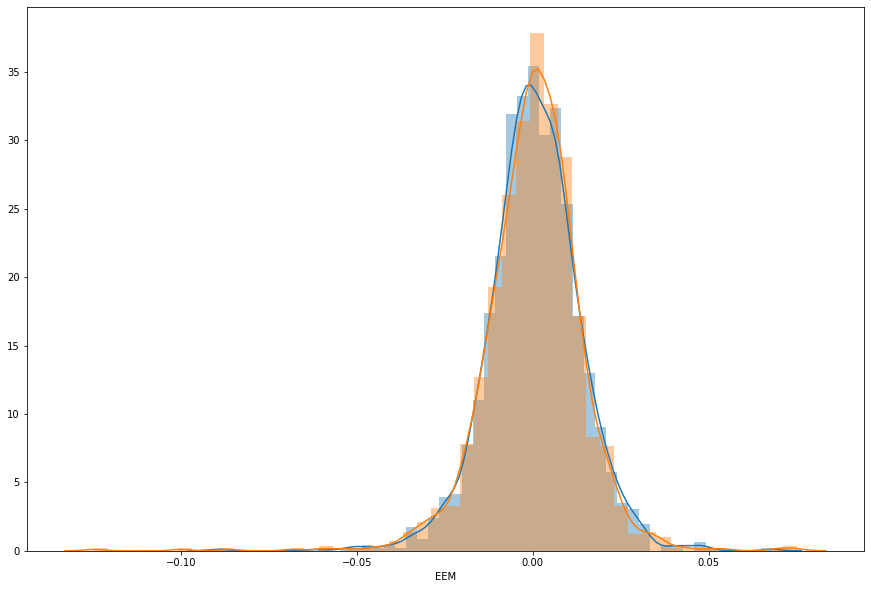

In [31]:
fig, ax = plt.subplots(figsize=(15,10))
sns.distplot(synthetic.iloc[:,0], ax=ax)
sns.distplot(daily_returns_df.iloc[:, 0], ax=ax)

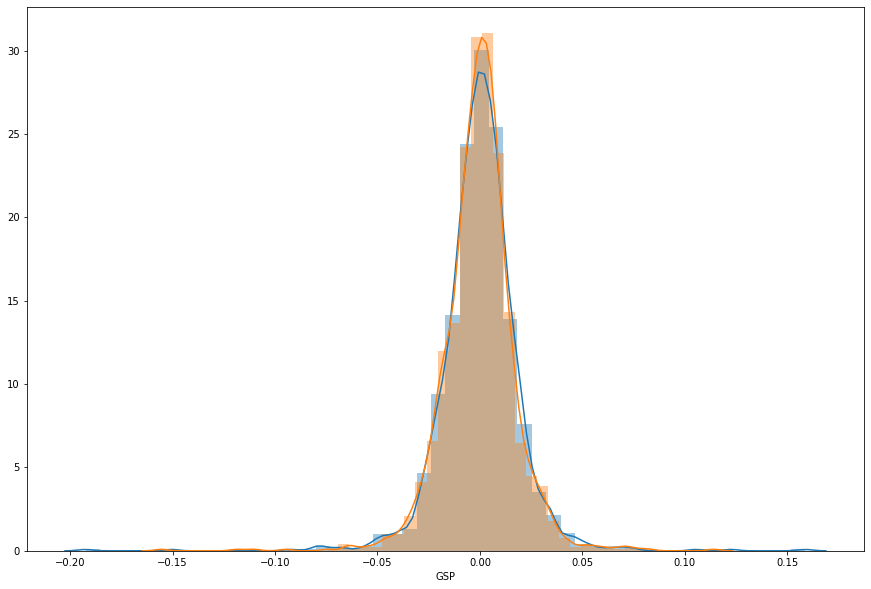

In [32]:
fig, ax = plt.subplots(figsize=(15,10))
sns.distplot(synthetic.iloc[:,1], ax=ax)
sns.distplot(daily_returns_df.iloc[:, 1], ax=ax)

### Its important to note that Copulas package does not support multivariate t-distribution

## 2. Experiment using [Copulae](https://copulae.readthedocs.io/en/latest/) package

In [33]:
from copulae import StudentCopula

copula_t = StudentCopula(dim=len(daily_returns_df.columns))
copula_t.fit(data=daily_returns_df)

In [34]:
copula_t.summary()

Student Copula Summary
================================================================================
Student Copula with 5 dimensions


Parameters
--------------------------------------------------------------------------------
 Degree of Freedom  : 4.5182244412034915

 Correlation Matrix 
 1.000000  0.416125  0.412176  0.759960 -0.282455
 0.416125  1.000000  0.133869  0.371586 -0.241410
 0.412176  0.133869  1.000000  0.573628 -0.008426
 0.759960  0.371586  0.573628  1.000000 -0.368333
-0.282455 -0.241410 -0.008426 -0.368333  1.000000



                                  Fit Summary                                   
================================================================================
Log. Likelihood      : -1475.3883930705165
Variance Estimate    : Not Implemented Yet
Method               : Maximum pseudo-likelihood
Data Points          : 1441

Optimization Setup
--------------------------------------------------------------------------------
	bounds         : [(0.0, inf), (-1.0, 1.0), (-1.0, 1.0), (-1.0, 1.0), (-1.0, 1.0), (-1.0, 1.0), (-1.0, 1.0), (-1.0, 1.0), (-1.0, 1.0), (-1.0, 1.0), (-1.0, 1.0)]
	options        : {'maxiter': 20000, 'ftol': 1e-06, 'iprint': 1, 'disp': False, 'eps': 1.5e-08}
	method         : SLSQP

Results
--------------------------------------------------------------------------------
	x              : [ 4.51822444  0.41612453  0.41217576  0.75995994 -0.28245488  0.13386936
  0.37158626 -0.2414102   0.5736284  -0.00842558 -0.36833321]
	fun            : -1475.3883930705165
	jac            : [ 0.00031832  0.02073648 -0.01267229  0.01391527  0.01106552 -0.01388495
 -0.00663931  0.00703343  0.01926613  0.0117628  -0.01312704]
	nit            : 16
	nfev           : 234
	njev           : 16
	status         : 0
	message        : Optimization terminated successfully.
	success        : True

In [35]:
from copulae.stats import multivariate_t as mvt, t
copula_t_synthetic = mvt.rvs(cov=copula_t.sigma, df=copula_t._df, size=len(daily_returns_df))
copula_t_synthetic = pd.DataFrame(copula_t_synthetic)

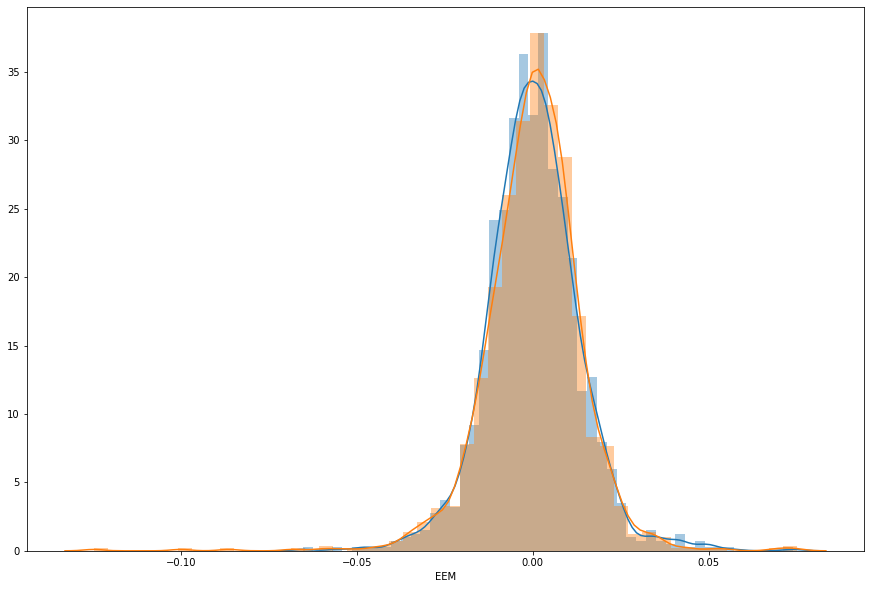

In [36]:
fig, ax = plt.subplots(figsize=(15,10))
sns.distplot(copula_t_synthetic.iloc[:,0] / 100, ax=ax)
sns.distplot(daily_returns_df.iloc[:,0], ax=ax)

In [37]:
copula_t_synthetic.columns = daily_returns_df.columns

In [38]:
weights = [1/len(synthetic.columns) for i in range(0, len(synthetic.columns))]
daily_portfolio_returns_df = daily_returns_df * weights
daily_portfolio_returns_df['portfolio_ret'] = daily_portfolio_returns_df.sum(axis=1)

## 3. Risk metrics using copulas 

[Krokhmal et. al. 2001, *Portfolio Optimization with Conditional Value-at-Risk Objective and Constraints*](https://www.ise.ufl.edu/uryasev/files/2011/11/kro_CVaR.pdf)

### Compute <span style="color:red">Gaussian copula</span> Value-at-risk and Expected Shortfall (CVaR) of a equal weight portfolio

In [39]:
portfolio_returns_df = synthetic * weights
portfolio_returns_df['portfolio_ret'] = portfolio_returns_df.sum(axis=1)

#synthetic.quantile(0.1) * 100

In [40]:
copula_portfolio_VaR = portfolio_returns_df.quantile(0.1)['portfolio_ret']
copula_portfolio_CVaR = np.mean(portfolio_returns_df['portfolio_ret'][portfolio_returns_df['portfolio_ret'] < - copula_portfolio_VaR])
print('Portfolio copula VaR', copula_portfolio_VaR * 100, 'CVaR', copula_portfolio_CVaR * 100)

Portfolio copula VaR -0.8919361161456156 CVaR -0.13864033844452495


### Compute <span style="color:red">Gaussian</span> Value-at-risk and Expected Shortfall (CVaR) of a equal weight portfolio

In [41]:
covariance = daily_returns_df.cov()
mean_vec = daily_returns_df.mean(axis=0)
norm_synthetic = pd.DataFrame(st.multivariate_normal.rvs(mean_vec, covariance, size=100))
portfolio_norm_returns_df = norm_synthetic * weights
portfolio_norm_returns_df['portfolio_ret'] = portfolio_norm_returns_df.sum(axis=1)

norm_portfolio_VaR = portfolio_norm_returns_df.quantile(0.1)['portfolio_ret']
norm_portfolio_CVaR = np.mean(portfolio_norm_returns_df['portfolio_ret'][portfolio_norm_returns_df['portfolio_ret'] < - norm_portfolio_VaR])
print('Portfolio normal VaR', norm_portfolio_VaR * 100, 'CVaR', norm_portfolio_CVaR * 100)

Portfolio normal VaR -0.9197950296941972 CVaR -0.17795231197447395


### Compute <span style="color:red">t-student copula</span> Value-at-risk and Expected Shortfall (CVaR) of a equal weight portfolio

In [42]:
portfolio_t_returns_df = copula_t_synthetic * weights
portfolio_t_returns_df['portfolio_ret'] = portfolio_t_returns_df.sum(axis=1)

In [43]:
portfolio_t_returns_df.head()

,EEM,GSP,RWR,SPY,TLT,portfolio_ret
0,-0.087858,0.239093,-0.293232,0.049974,-0.245711,-0.337734
1,0.080308,0.266562,-0.182146,-0.038091,0.160457,0.287091
2,-0.134852,-0.249738,-0.648946,-0.160473,-0.288185,-1.482195
3,0.155858,0.257802,-0.106451,0.159674,-0.392747,0.074136
4,-0.212004,0.158389,-0.111128,-0.046823,0.237209,0.025643


In [44]:
copula_t_portfolio_VaR = portfolio_t_returns_df.quantile(0.1)['portfolio_ret']
copula_t_portfolio_CVaR = np.mean(portfolio_t_returns_df['portfolio_ret'][portfolio_t_returns_df['portfolio_ret'] < - copula_t_portfolio_VaR])
print('Portfolio copula t VaR', copula_t_portfolio_VaR, 'CVaR', copula_t_portfolio_CVaR)

Portfolio copula t VaR -0.8417577919560382 CVaR -0.153103959461512


Text(0.5, 1.0, 't-Student Copula Samples')

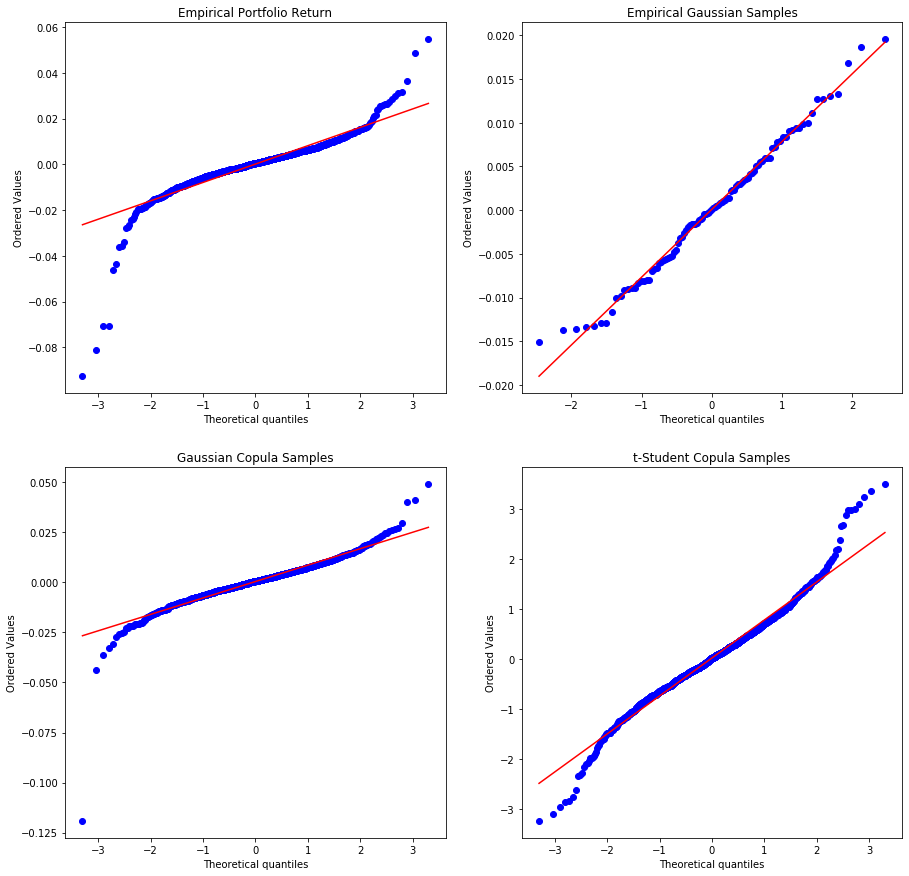

In [45]:
nsample = 100
fig, ax = plt.subplots(figsize=(15,15))

ax1 = plt.subplot(221)
x = daily_portfolio_returns_df['portfolio_ret']
res = st.probplot(x, plot=plt)
ax1.set_title('Empirical Portfolio Return')

ax2 = plt.subplot(222)
x = portfolio_norm_returns_df['portfolio_ret']
res = st.probplot(x, plot=plt)
ax2.set_title('Empirical Gaussian Samples')

ax3 = plt.subplot(223)
x = portfolio_returns_df['portfolio_ret']
res = st.probplot(x, plot=plt)
ax3.set_title('Gaussian Copula Samples')

ax4 = plt.subplot(224)
x = portfolio_t_returns_df['portfolio_ret']
res = st.probplot(x, plot=plt)
ax4.set_title('t-Student Copula Samples')

## 4. Copula fit for currencies


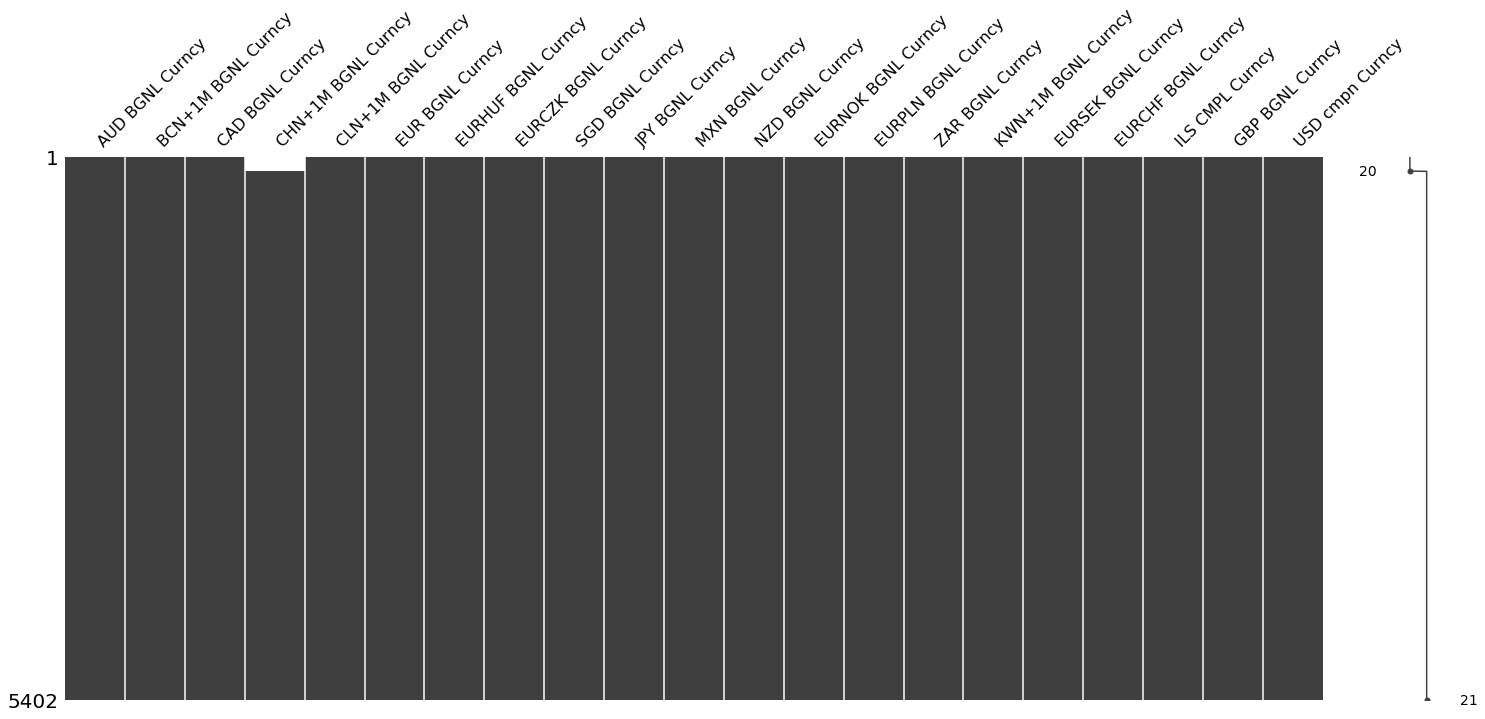

In [46]:
import pandas as pd
fx_df = pd.read_excel('moedas_frodi.xlsx')
fx_df = fx_df.set_index('date')
import missingno as msno 
msno.matrix(fx_df)

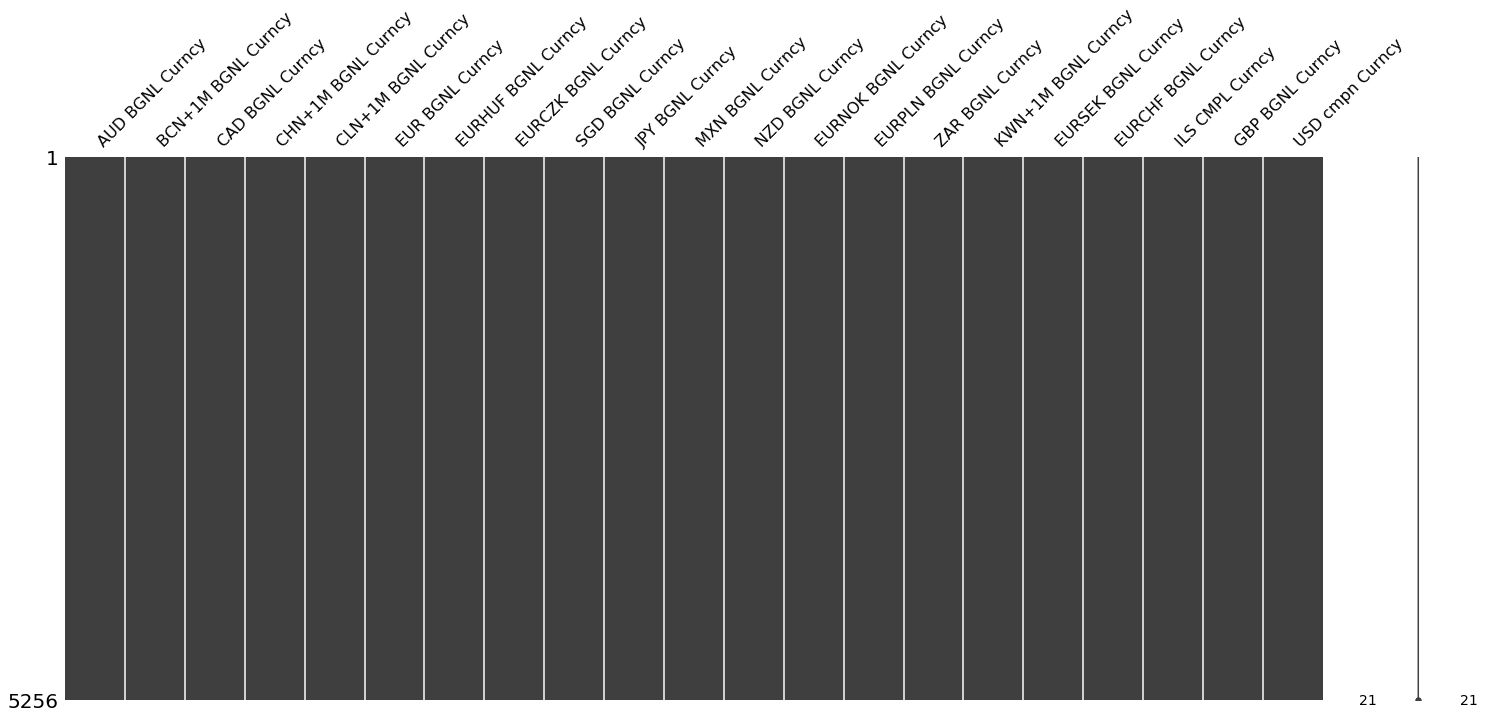

In [47]:
fx_notnan_df = fx_df.pct_change(1).dropna()
msno.matrix(fx_notnan_df)

In [48]:
del fx_notnan_df['USD cmpn Curncy']
fx_notnan_df

,AUD BGNL Curncy,BCN+1M BGNL Curncy,CAD BGNL Curncy,CHN+1M BGNL Curncy,CLN+1M BGNL Curncy,EUR BGNL Curncy,EURHUF BGNL Curncy,EURCZK BGNL Curncy,SGD BGNL Curncy,JPY BGNL Curncy,MXN BGNL Curncy,NZD BGNL Curncy,EURNOK BGNL Curncy,EURPLN BGNL Curncy,ZAR BGNL Curncy,KWN+1M BGNL Curncy,EURSEK BGNL Curncy,EURCHF BGNL Curncy,ILS CMPL Curncy,GBP BGNL Curncy
date,,,,,,,,,,,,,,,,,,,,
2000-07-26,0.010256,0.000719,0.000000,0.009628,0.009930,0.003943,-0.001917,-0.000337,-0.001433,0.000366,0.000481,0.002392,0.000256,-0.000618,-0.003952,-0.000448,0.000428,0.000419,0.000000,-0.001515
2000-07-27,-0.004061,-0.003429,0.003547,0.002159,-0.008327,-0.008916,0.000307,-0.001797,-0.005050,-0.001007,-0.000555,-0.005640,0.002148,-0.004301,0.000577,-0.001345,0.008266,-0.001256,0.000000,-0.002243
2000-07-28,-0.001019,-0.002275,0.004758,0.002334,0.010133,-0.011460,-0.001958,-0.001941,0.000288,0.003847,0.001304,-0.001309,-0.003361,-0.003252,0.003504,0.003142,-0.001899,-0.002193,0.000192,-0.006348
2000-07-31,-0.014796,-0.002225,0.005885,-0.000842,-0.000229,0.005092,0.001808,-0.001550,-0.000923,0.000639,-0.000427,-0.006772,0.003091,0.003063,-0.000043,0.000000,0.004515,-0.000032,0.002836,-0.002728
2000-08-01,0.001899,0.006410,0.002017,-0.004536,0.002865,-0.005713,0.000230,-0.000960,-0.001039,-0.002553,-0.002136,-0.003299,-0.001620,-0.003501,0.001265,-0.000895,0.000271,-0.000808,0.001175,-0.000400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-09-10,0.000137,0.004344,0.001672,0.004948,-0.001290,0.004660,-0.000140,0.003170,0.000512,-0.000659,-0.008460,-0.002545,0.004564,0.002500,0.013872,0.002017,0.002262,-0.000918,0.000000,-0.014063
2020-09-11,0.000824,0.002106,0.000152,-0.002138,-0.000487,-0.001012,0.001962,-0.000301,0.000146,-0.000188,-0.002522,0.000450,0.000682,-0.000494,-0.009147,0.000354,0.002681,-0.000418,0.004428,-0.002650
2020-09-14,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.001149,0.000000


In [49]:
fx_notnan_df.columns

Index(['AUD BGNL Curncy', 'BCN+1M BGNL Curncy', 'CAD BGNL Curncy',
       'CHN+1M BGNL Curncy', 'CLN+1M BGNL Curncy', 'EUR BGNL Curncy',
       'EURHUF BGNL Curncy', 'EURCZK BGNL Curncy', 'SGD BGNL Curncy',
       'JPY BGNL Curncy', 'MXN BGNL Curncy', 'NZD BGNL Curncy',
       'EURNOK BGNL Curncy', 'EURPLN BGNL Curncy', 'ZAR BGNL Curncy',
       'KWN+1M BGNL Curncy', 'EURSEK BGNL Curncy', 'EURCHF BGNL Curncy',
       'ILS CMPL Curncy', 'GBP BGNL Curncy'],
      dtype='object')

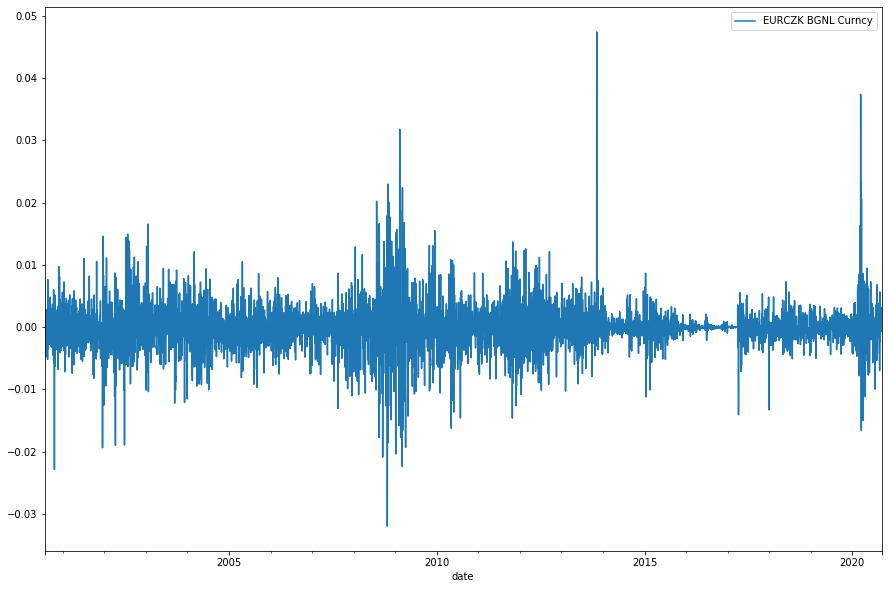

In [50]:
fx_notnan_df[['EURCZK BGNL Curncy']].plot(figsize=(15,10))

### Gaussian Copula + best fitted marginals

In [51]:
import time

init_time = time.time()
copula = GaussianMultivariate()
copula.fit(fx_notnan_df)
print('Time to fit Multivariate Gaussian copula for the best marginals ',(time.time() - init_time))

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_continuous_distns.py:547: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\ProgramData\Anaconda3\lib\site-packages\copulas\univariate\truncated_gaussian.py:43: RuntimeWarning: invalid value encountered in double_scalars
  a = (self.min - loc) / scale
C:\ProgramData\Anaconda3\lib\site-packages\copulas\univariate\truncated_gaussian.py:44: RuntimeWarning: divide by zero encountered in double_scalars
  b = (self.max - loc) / scale
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  wa

Time to fit Multivariate Gaussian copula for the best marginals  38.42978262901306


In [52]:
marginal_cdfs = {}
for i, j in enumerate(fx_notnan_df.columns):
    marginal = copula.univariates[i].cdf(fx_notnan_df.iloc[:,i])
    marginal_cdfs[j] = marginal
marginal_parametrica_df = pd.DataFrame.from_dict(marginal_cdfs)
marginal_parametrica_df.columns = [col.split()[0] + ' parametrica' for col in marginal_parametrica_df.columns]

In [57]:
marginal_normal_cdfs = {}
for i, j in enumerate(fx_notnan_df.columns):
    marginal = st.norm.cdf(fx_notnan_df.iloc[:,i],
                           loc=np.mean(fx_notnan_df.iloc[:,i]), scale=np.std(fx_notnan_df.iloc[:,i]))
    marginal_normal_cdfs[j] = marginal
marginal_normal_df = pd.DataFrame.from_dict(marginal_normal_cdfs)
marginal_normal_df.columns = [col.split()[0] + ' normal' for col in marginal_normal_df.columns]

In [54]:
from scipy.stats import percentileofscore

marginal_cdfs = {}
for i, col in enumerate(fx_notnan_df.columns):
    marginal_cdfs[col] = fx_notnan_df.iloc[:,i].apply(lambda x: percentileofscore(fx_notnan_df.iloc[:,i], x, kind='weak')) /100
marginal_empirica_df = pd.DataFrame.from_dict(marginal_cdfs)
marginal_empirica_df = marginal_empirica_df.reset_index(drop=True)
marginal_empirica_df.columns = [col.split()[0] + ' empirica' for col in marginal_empirica_df.columns]

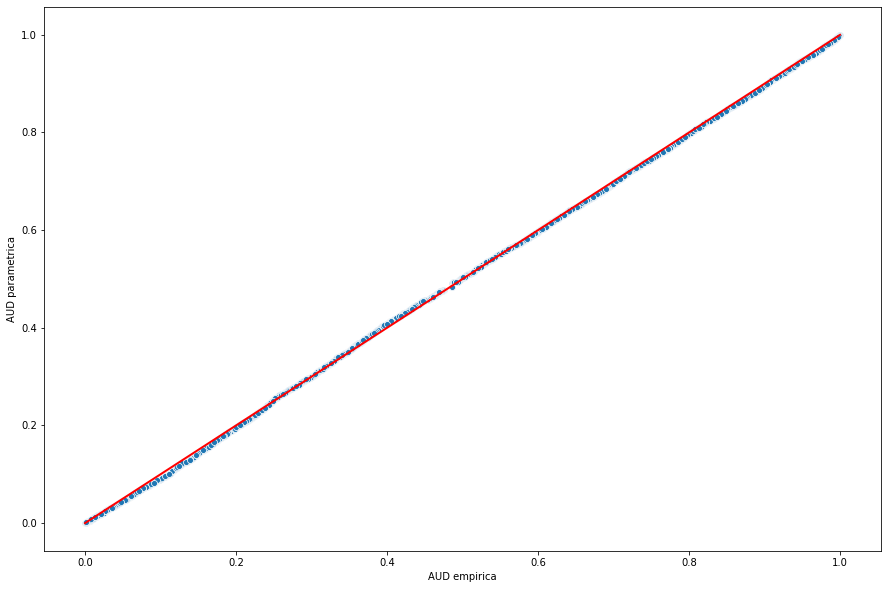

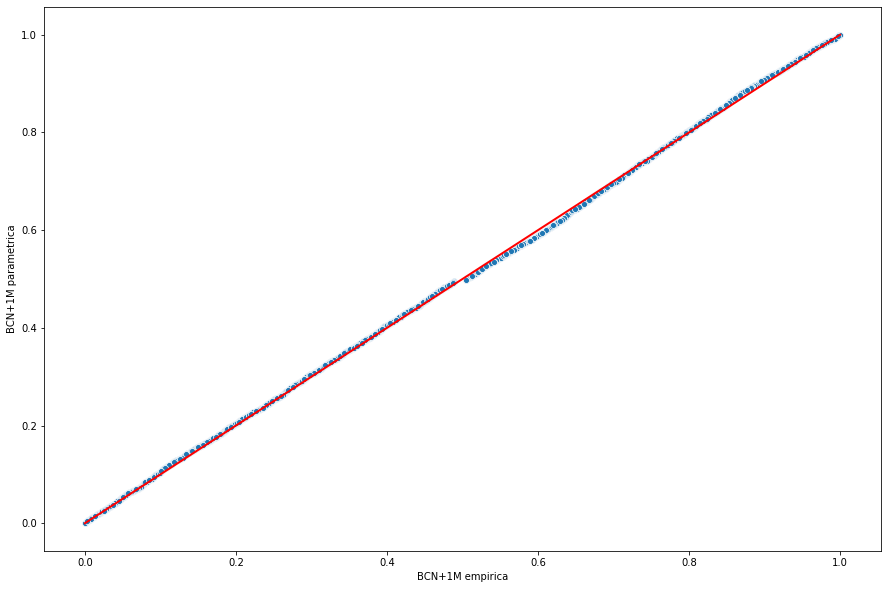

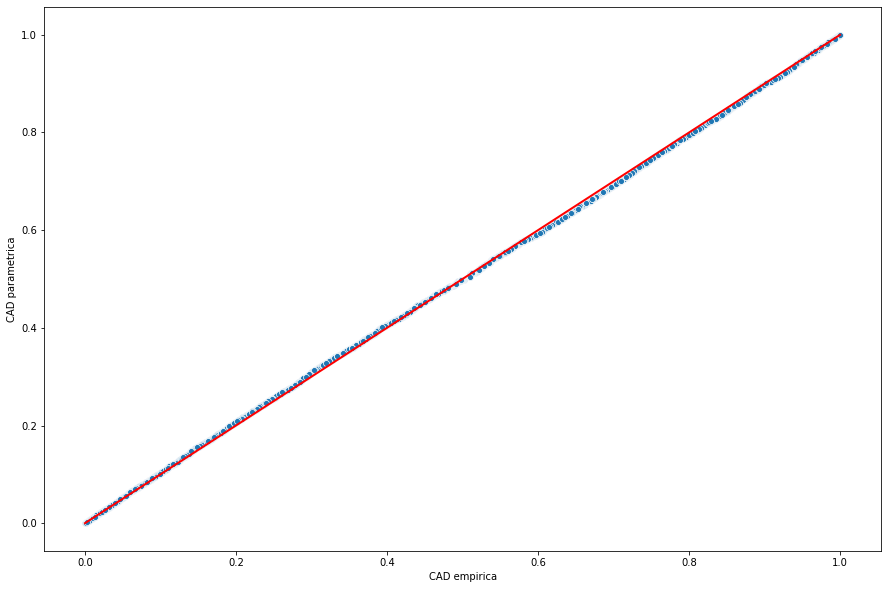

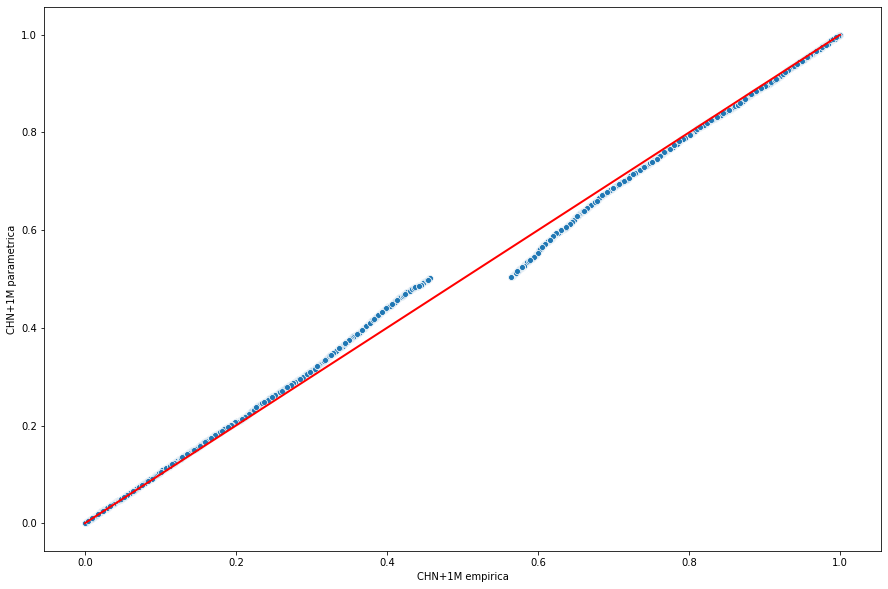

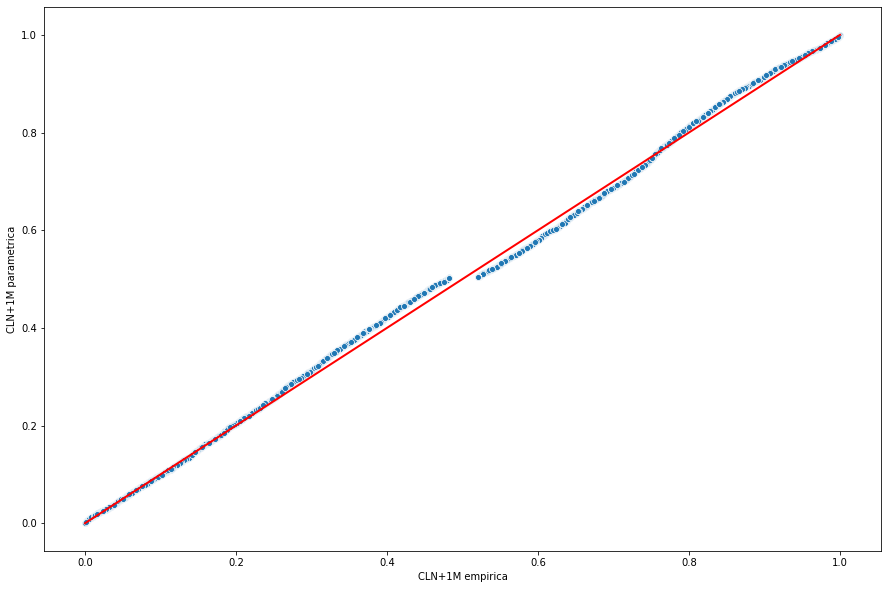

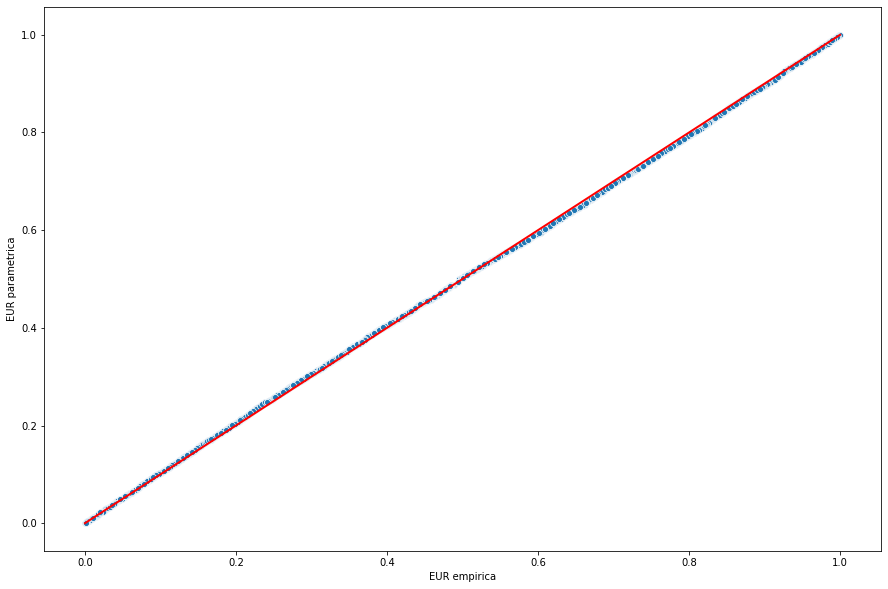

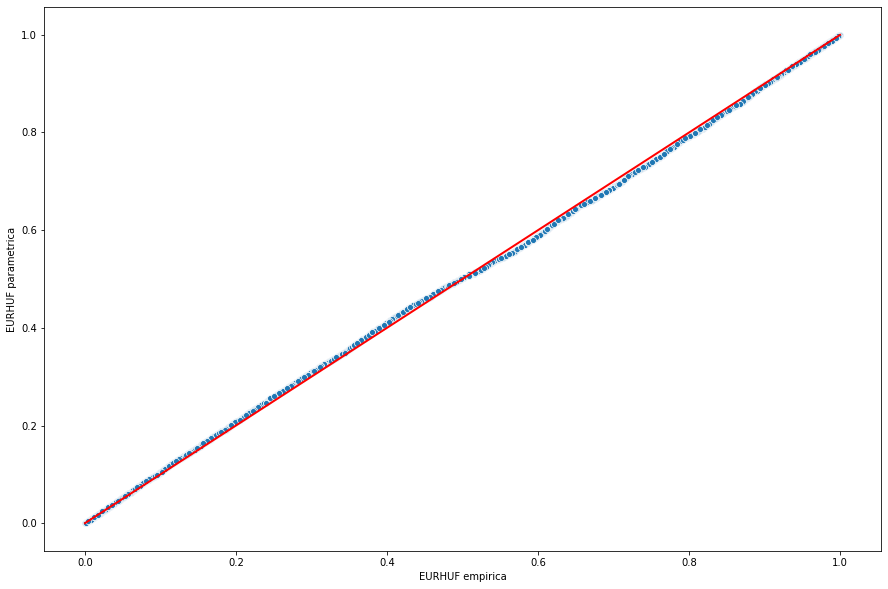

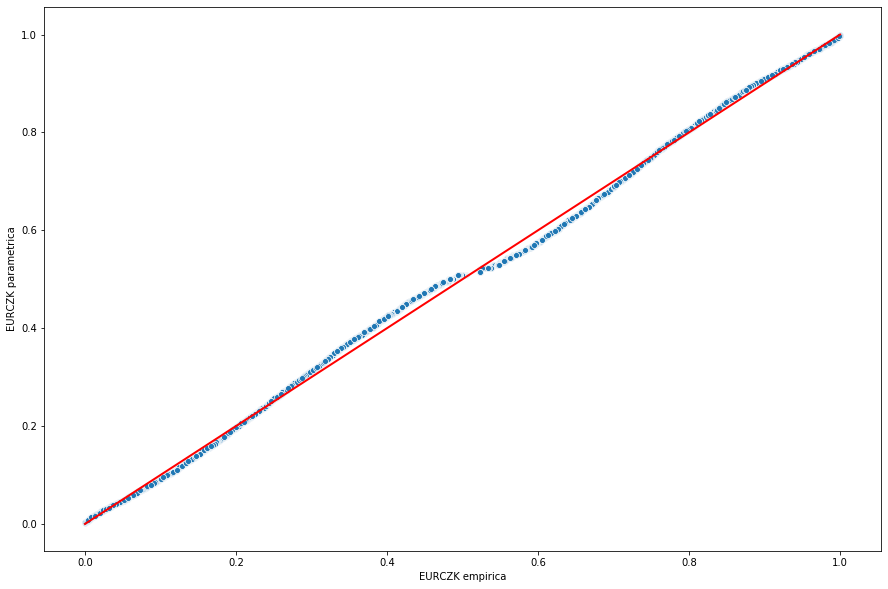

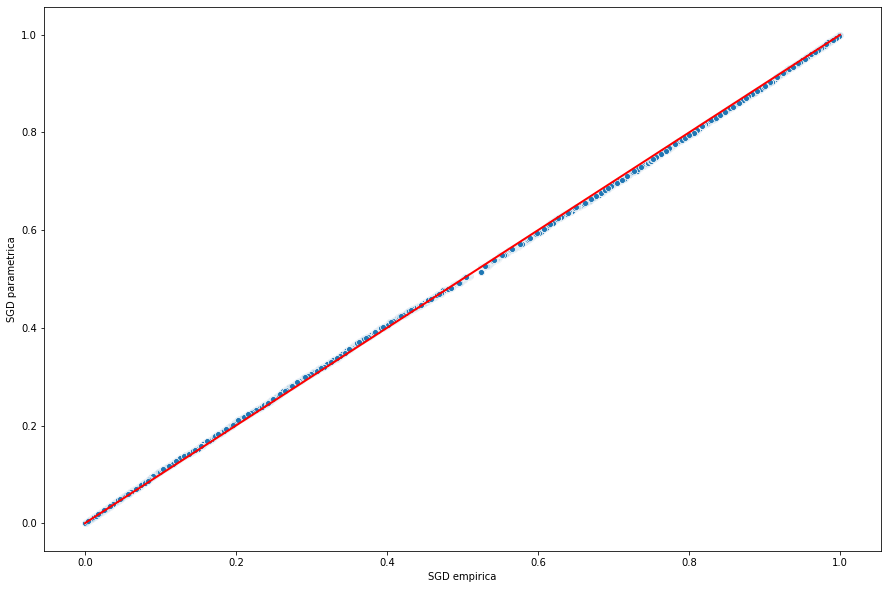

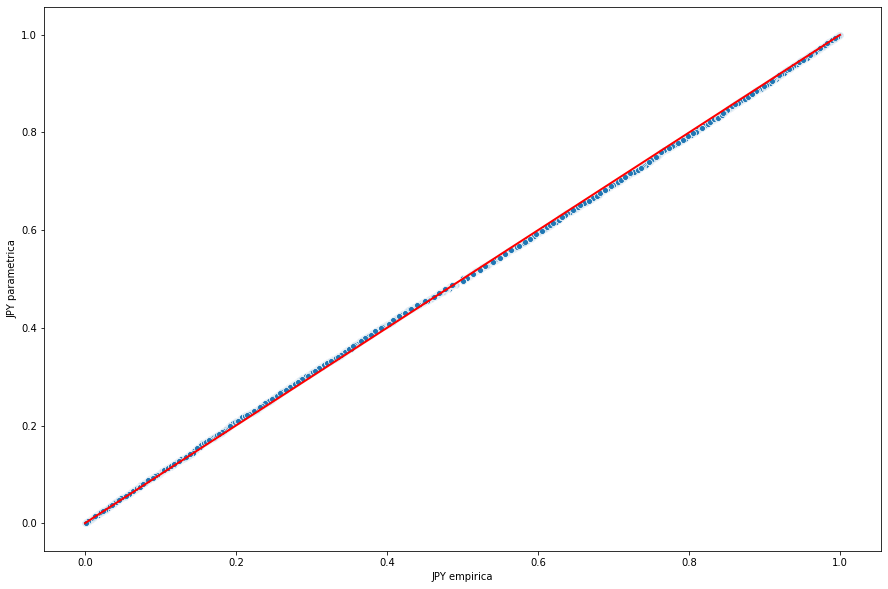

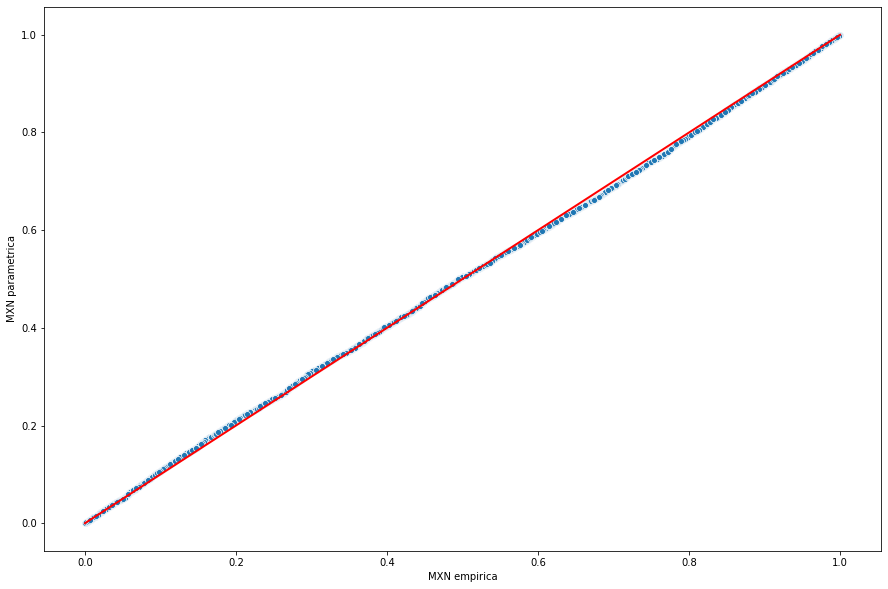

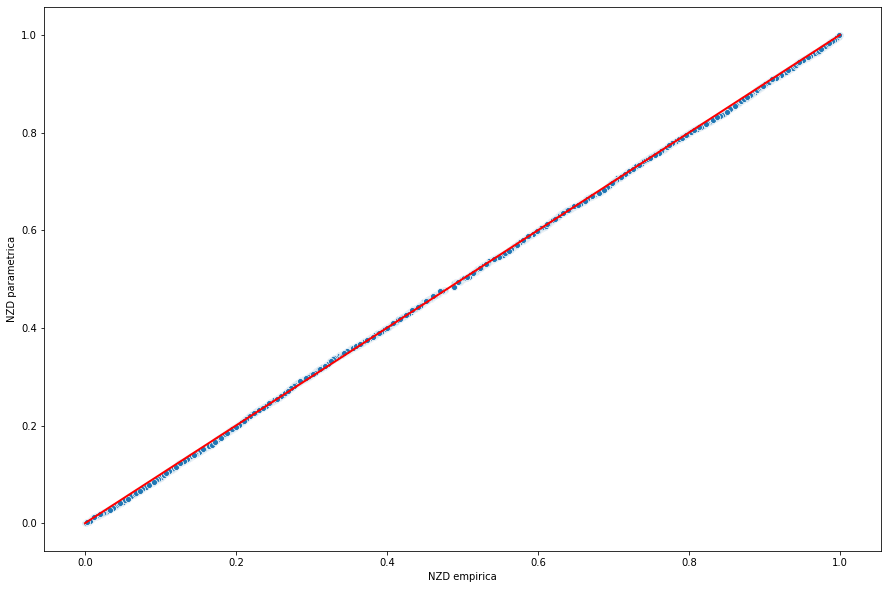

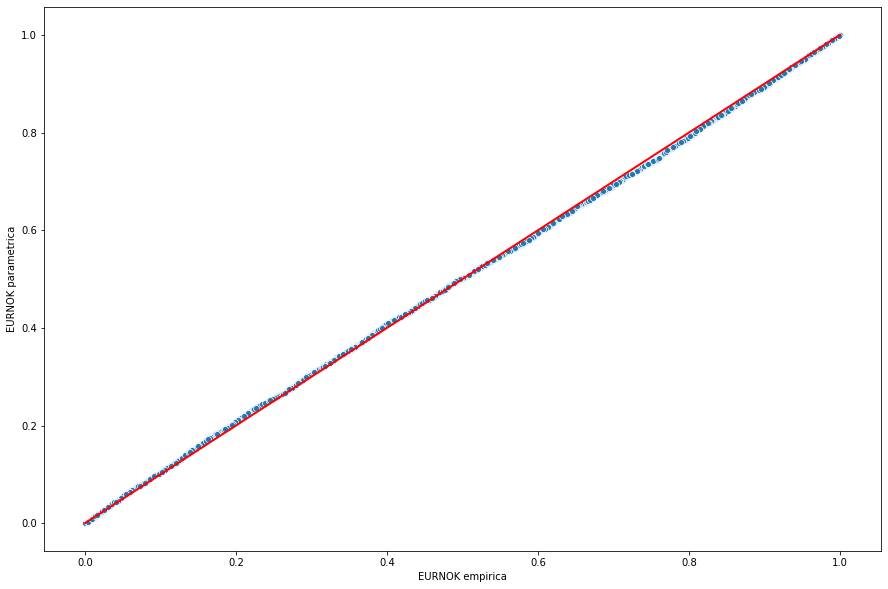

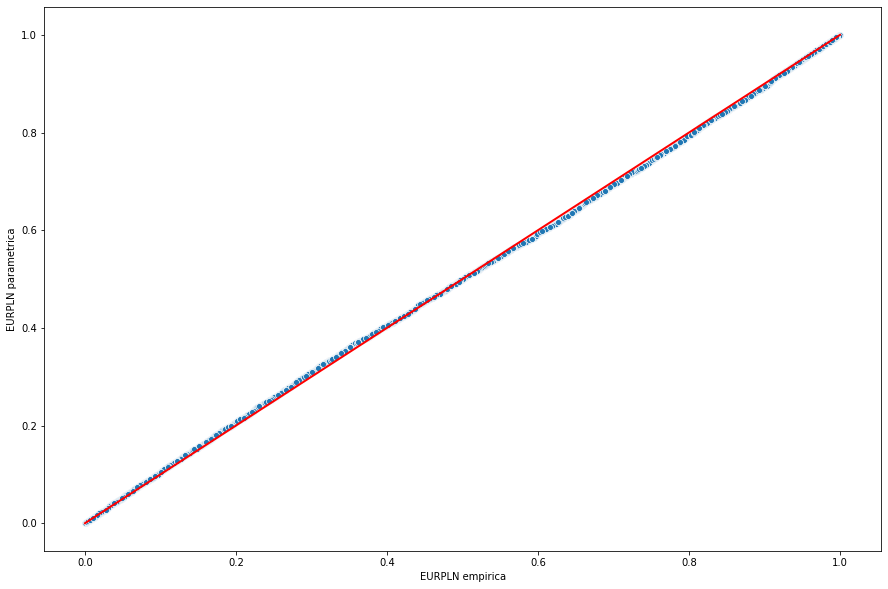

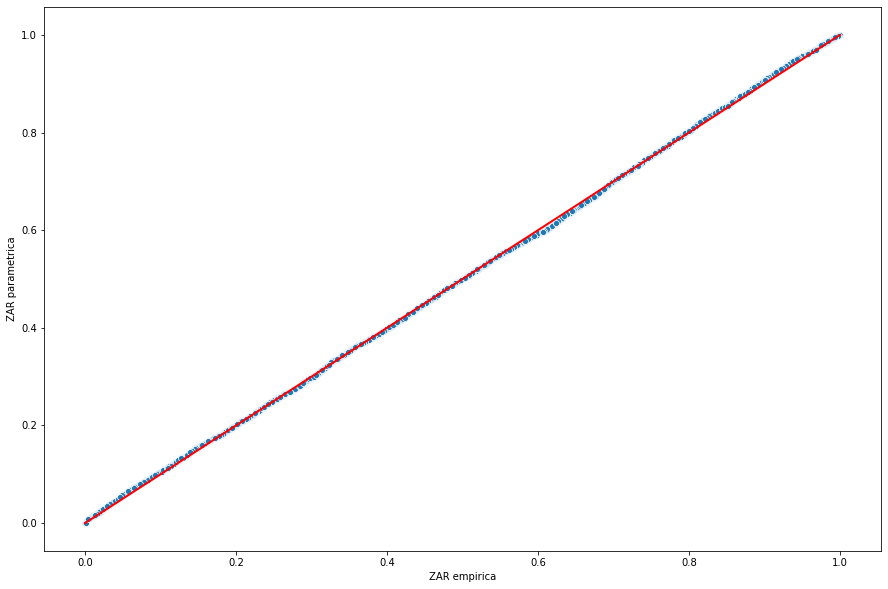

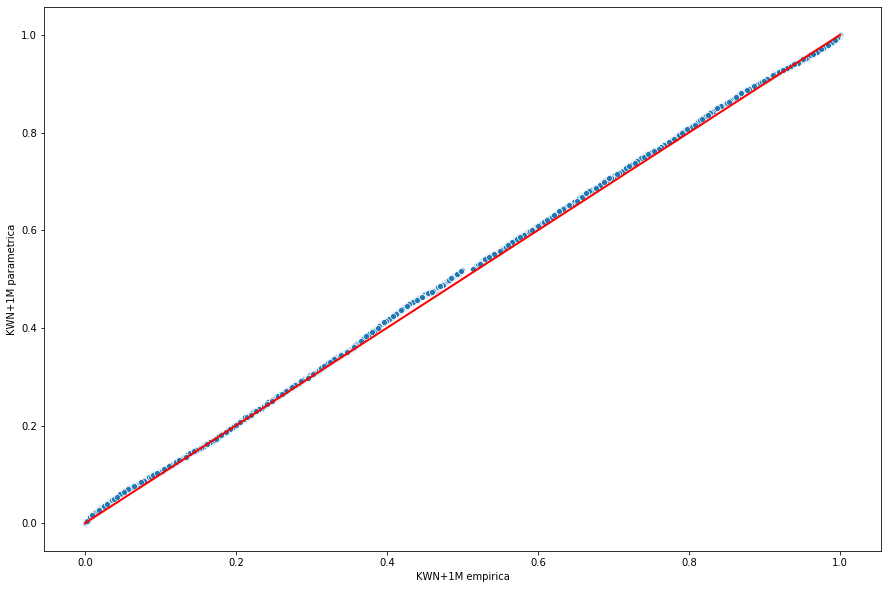

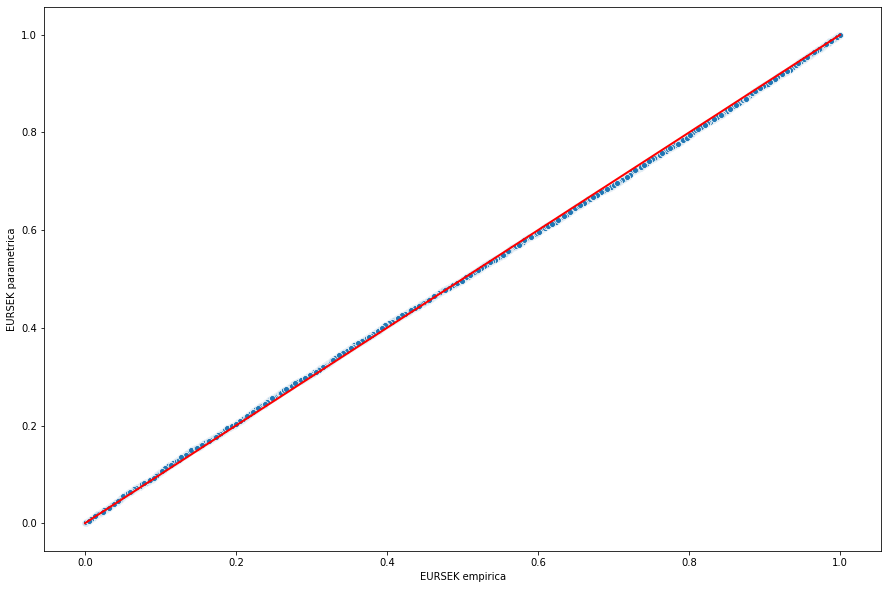

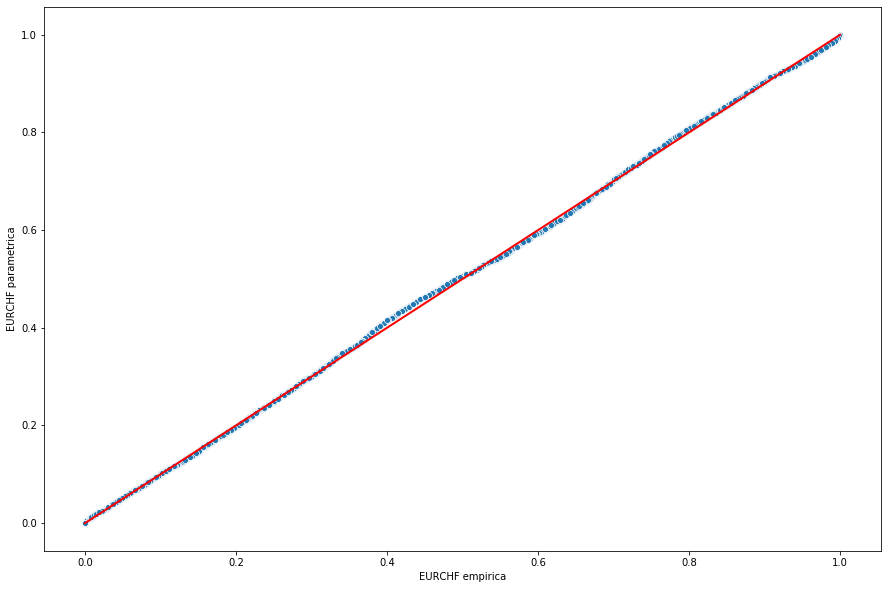

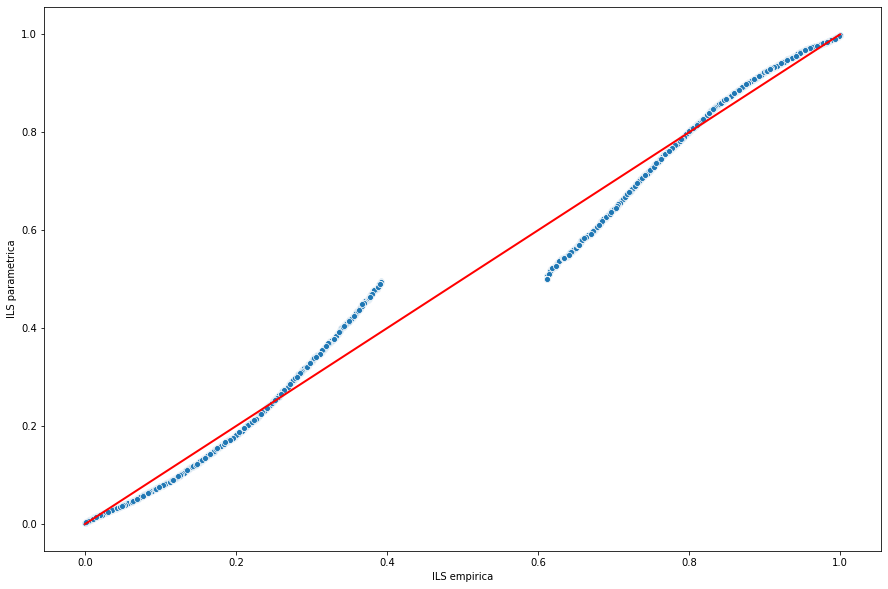

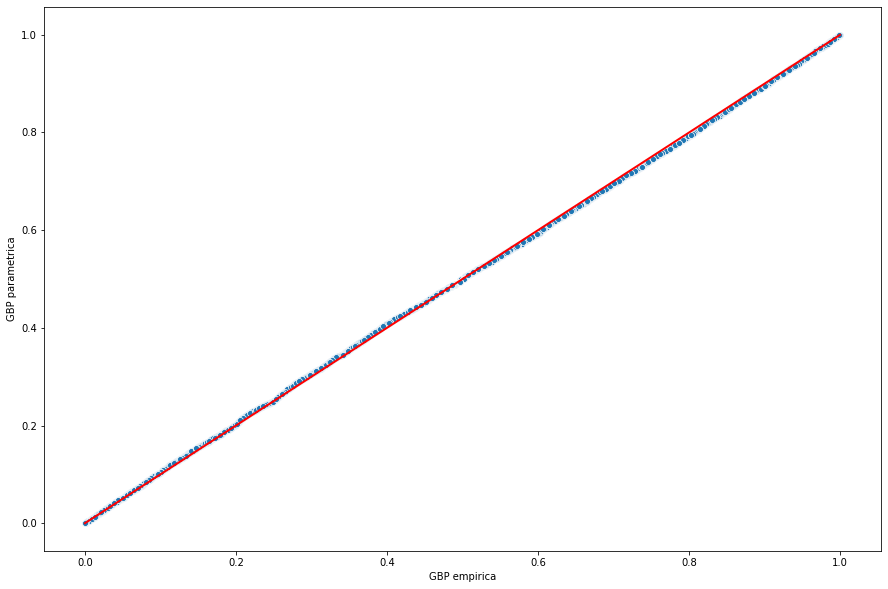

In [96]:
for col in marginal_empirica_df.columns:
    # series_name = 'EURSEK BGNL Curncy'

    fig, ax = plt.subplots(figsize=(15,10))
    plt.plot([0, 1], [0, 1], linewidth=2, color='r')
    sns.scatterplot(x=marginal_empirica_df[col], y=marginal_parametrica_df[col.split()[0] + ' parametrica'])

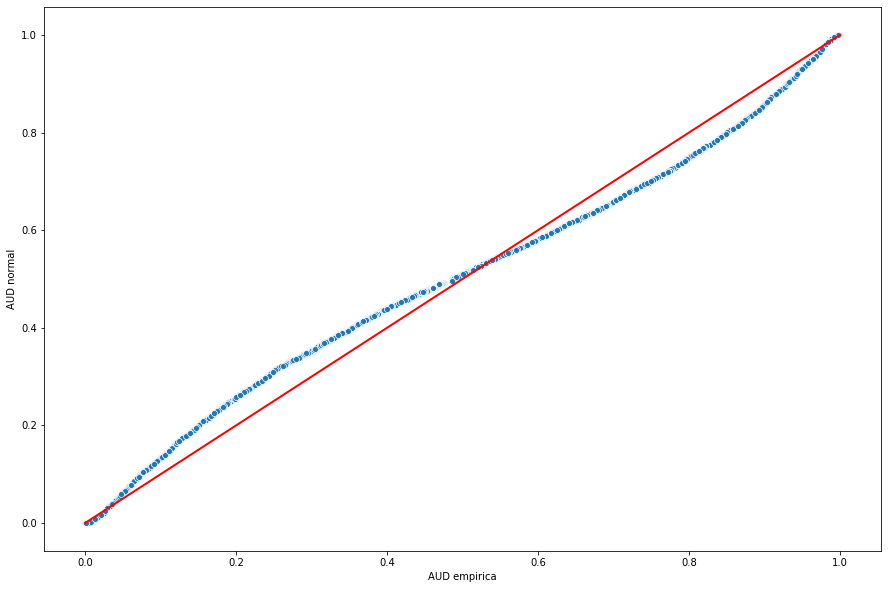

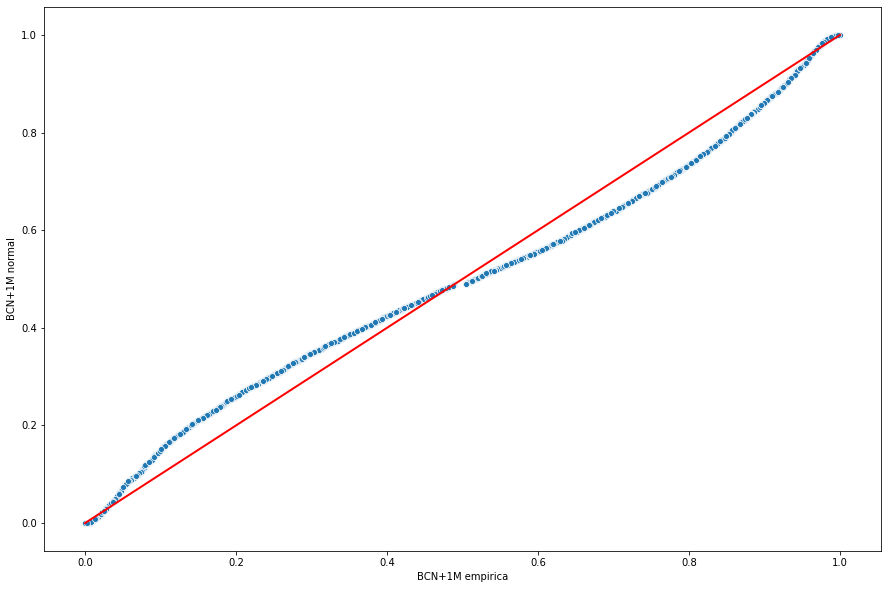

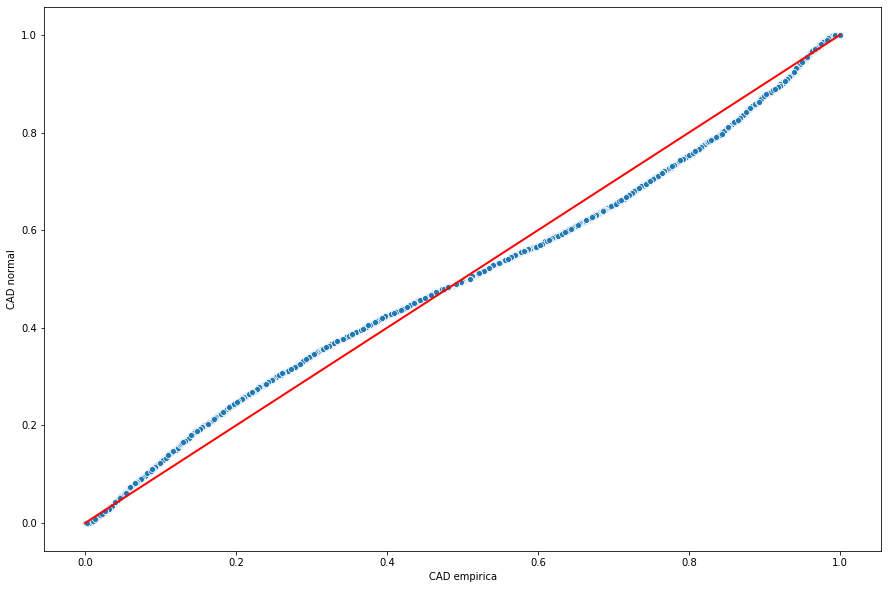

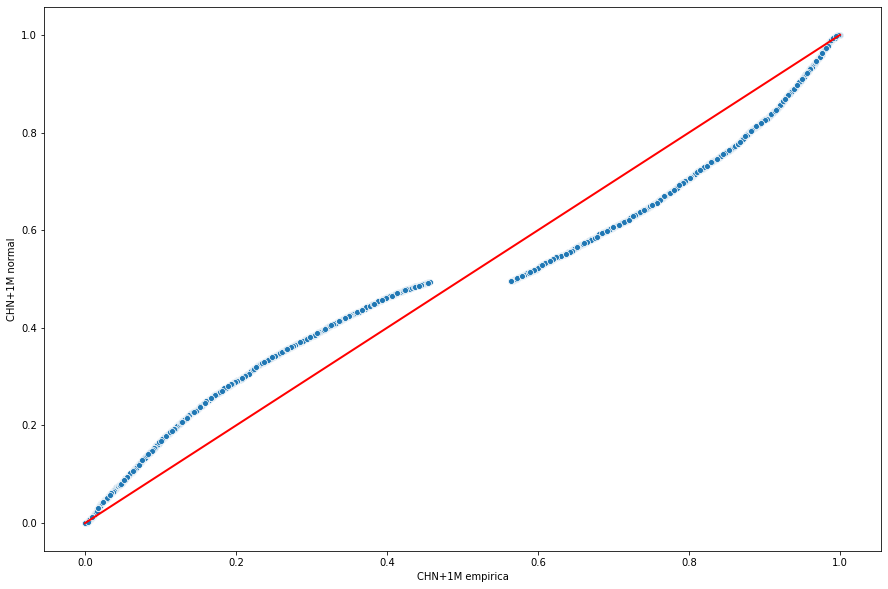

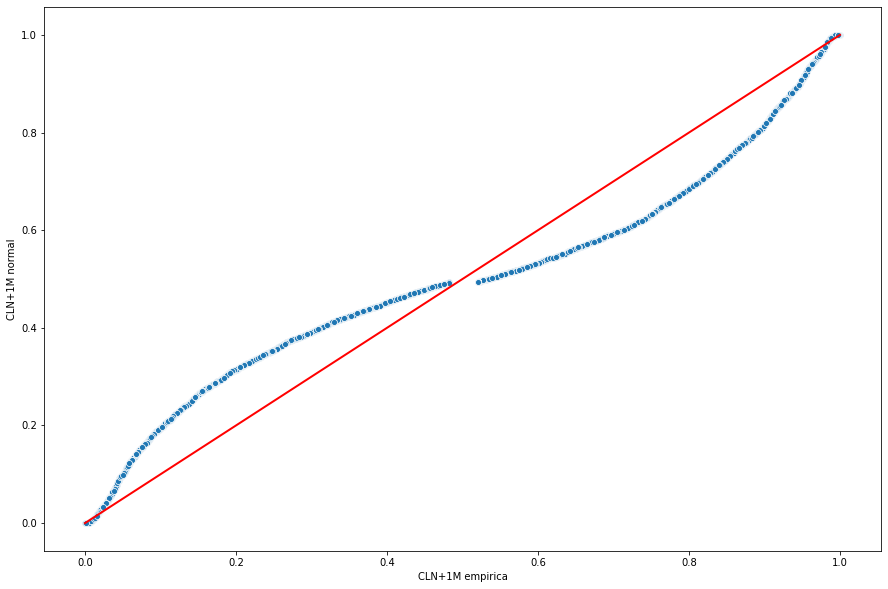

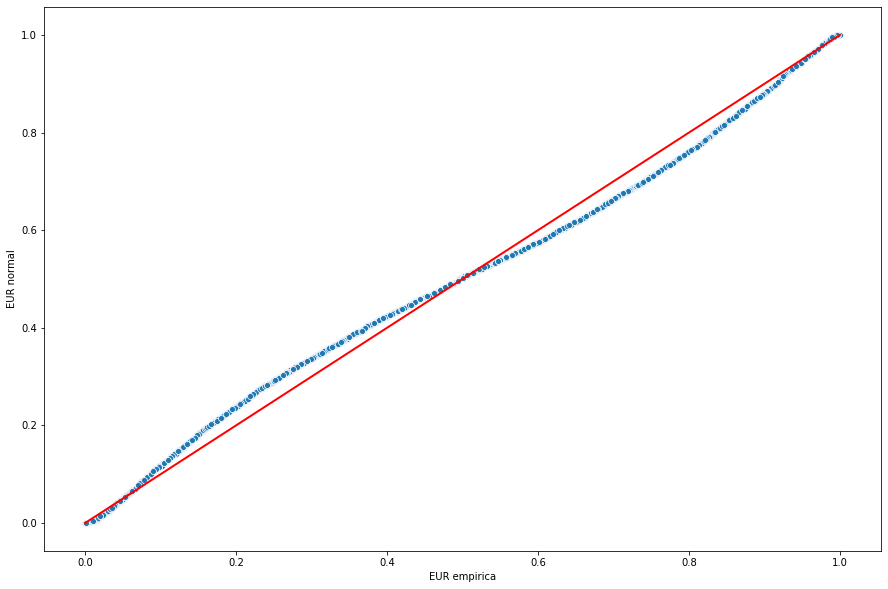

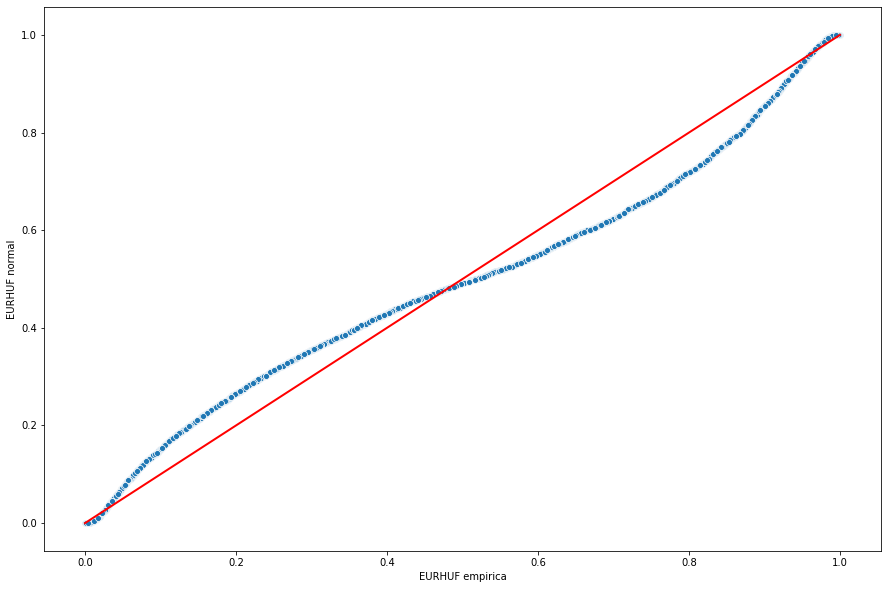

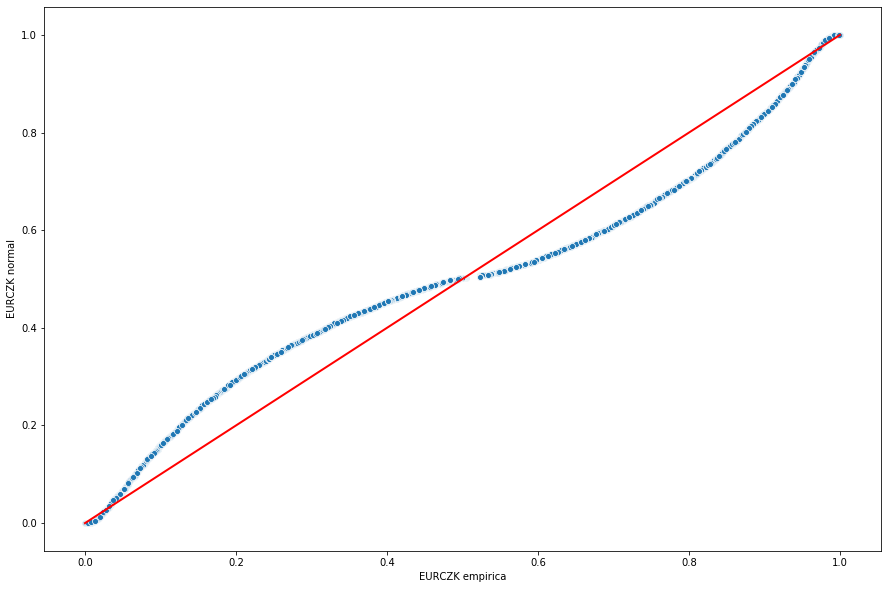

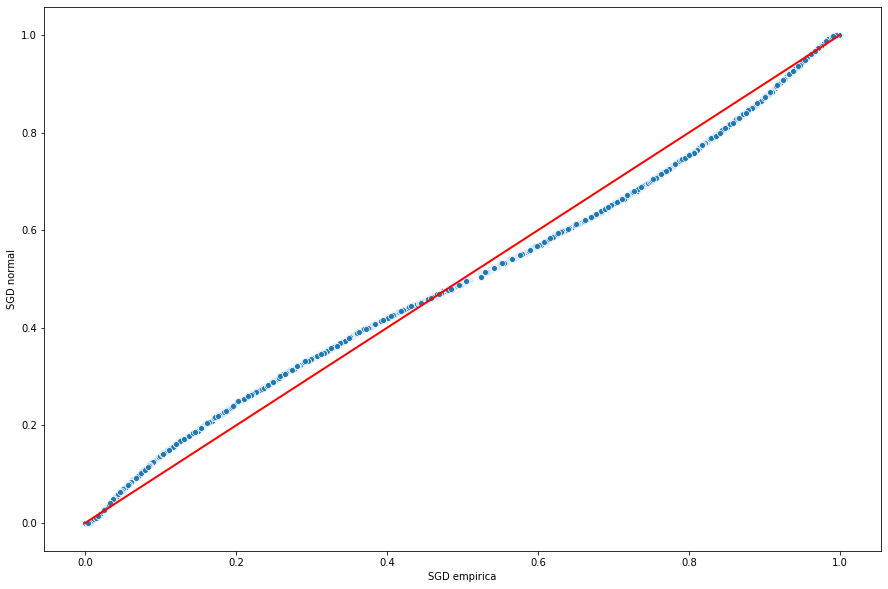

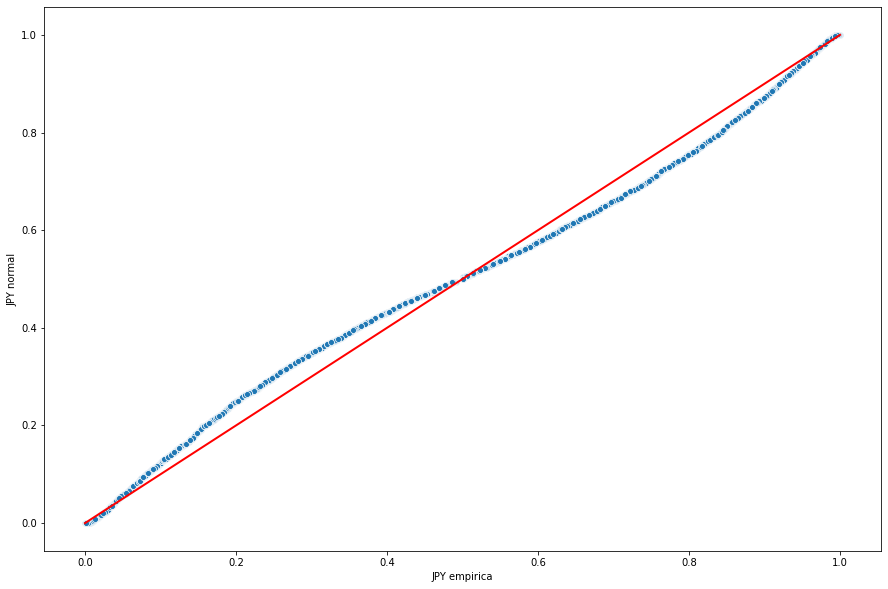

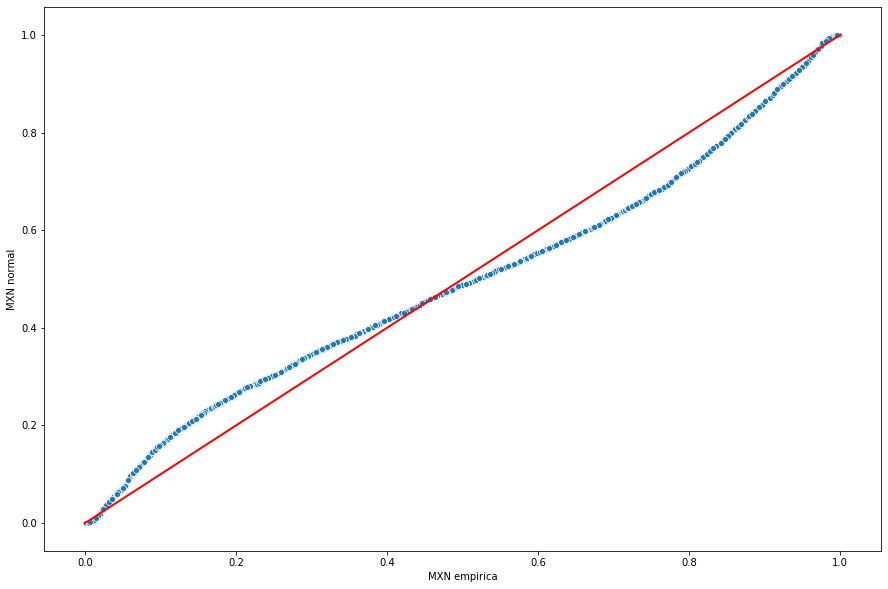

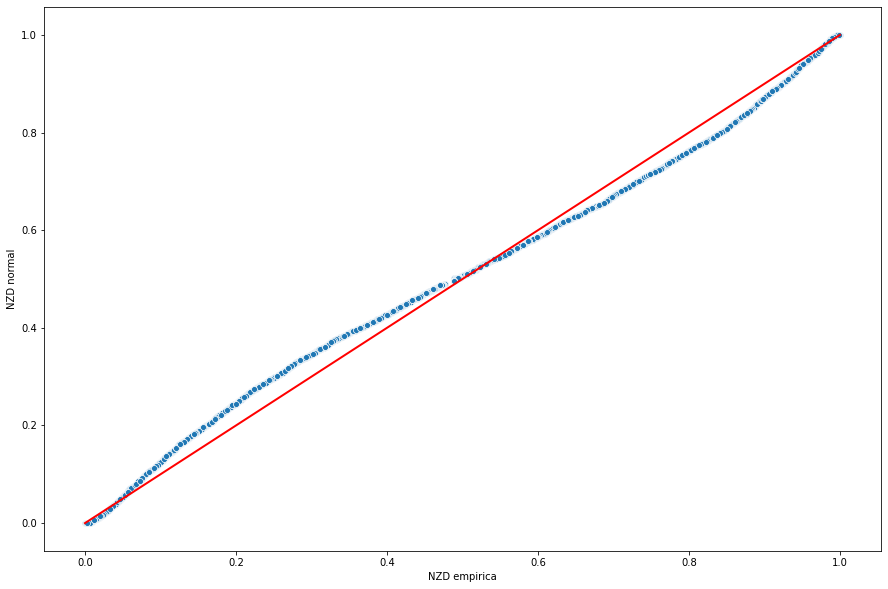

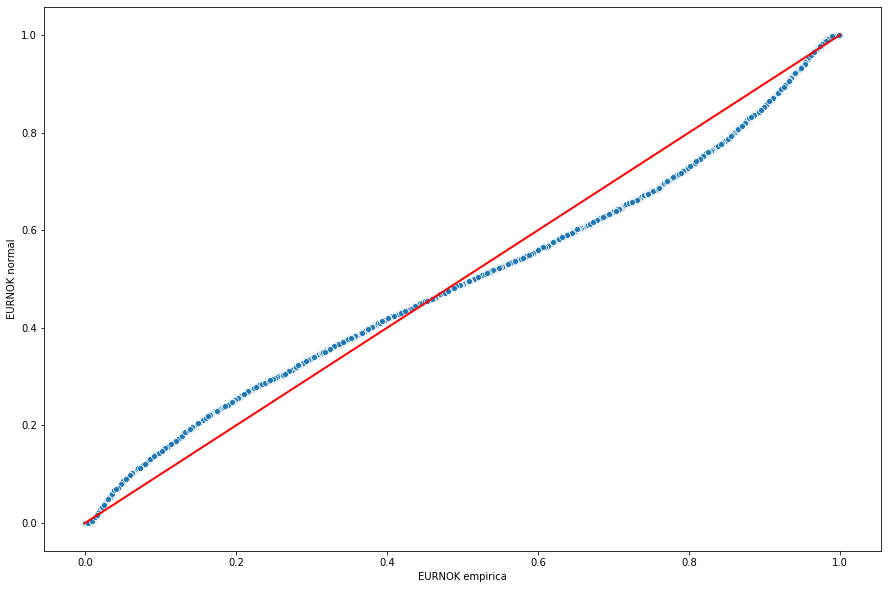

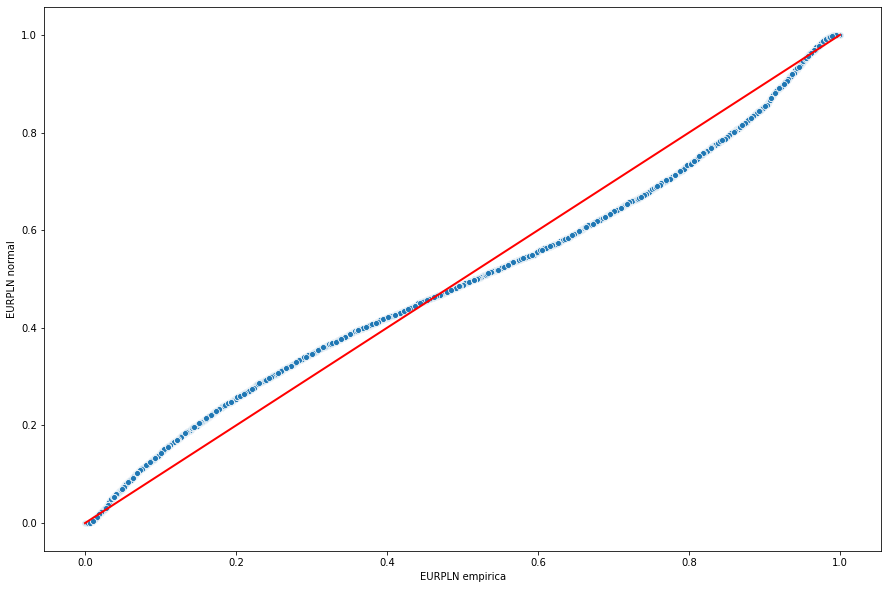

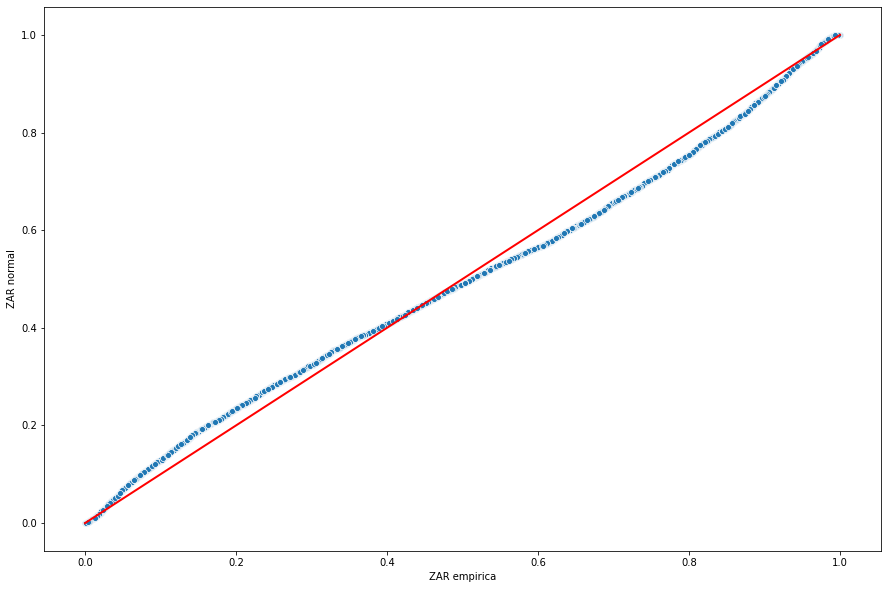

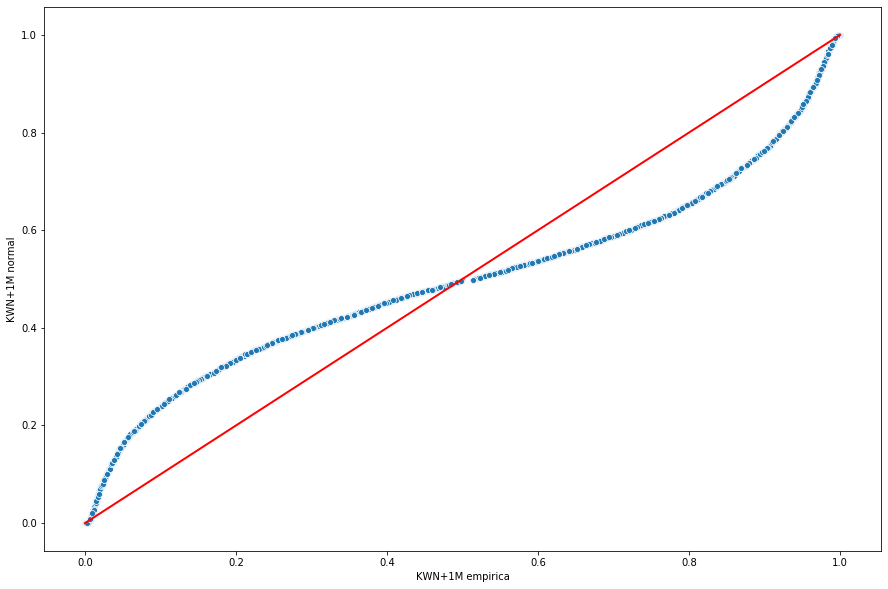

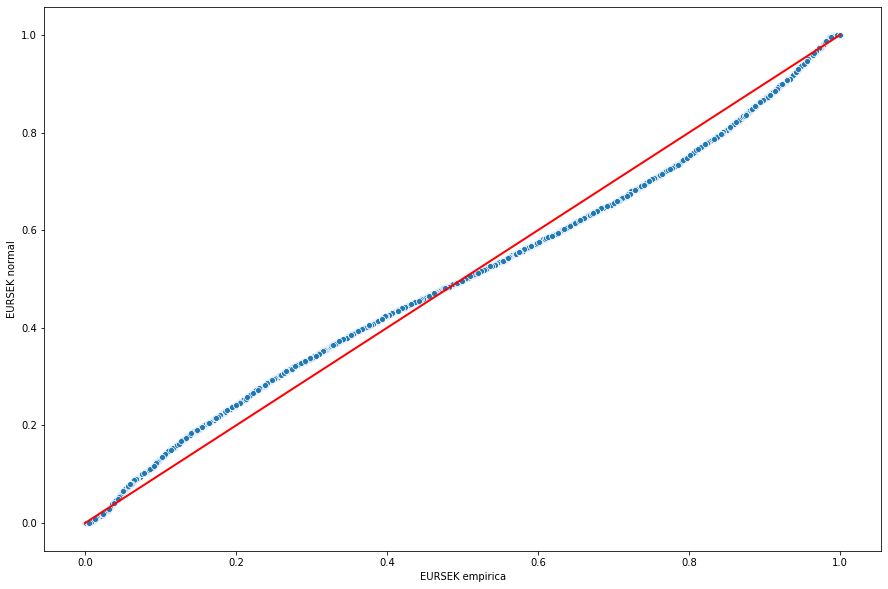

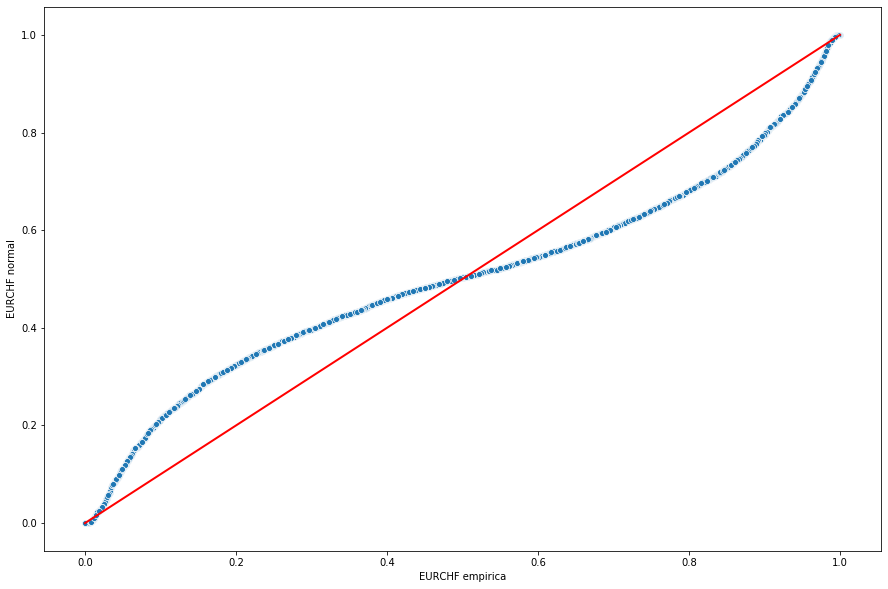

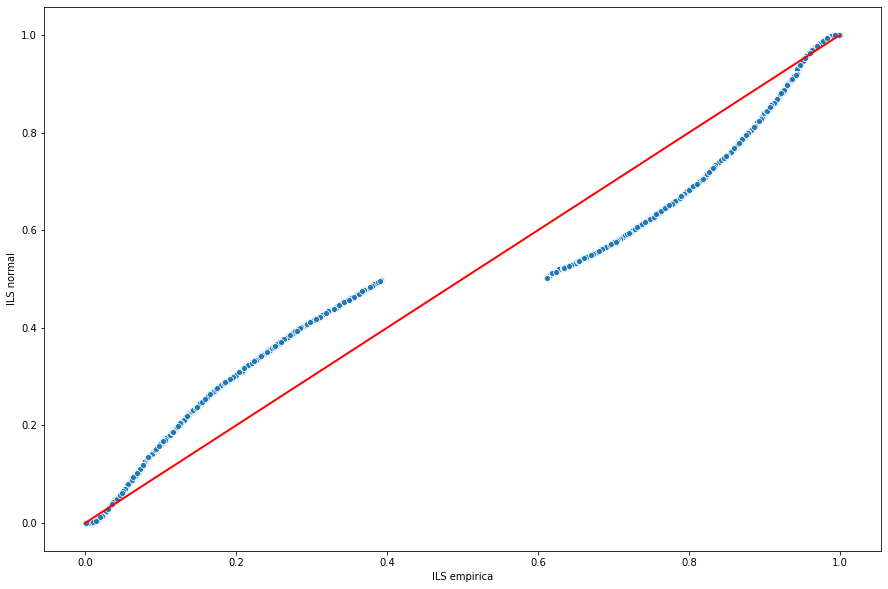

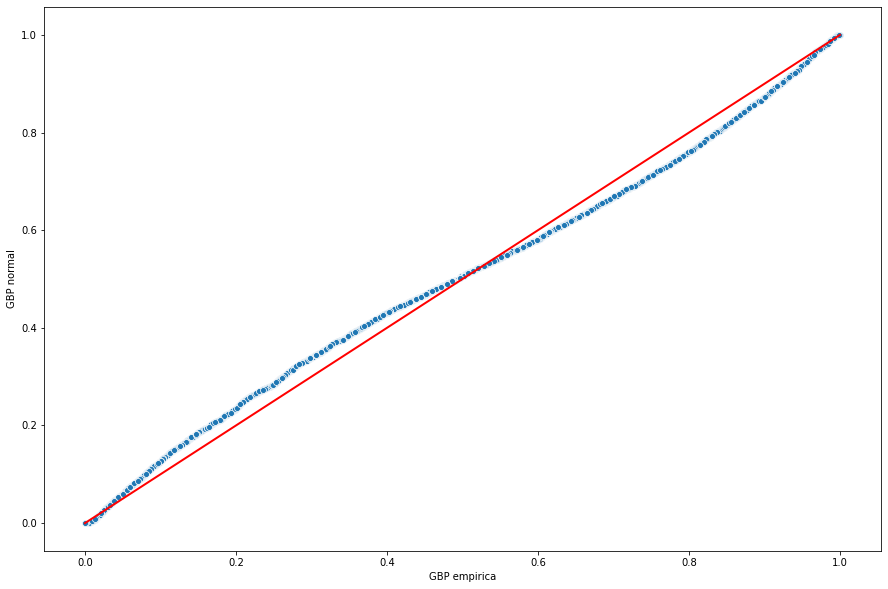

In [58]:
for col in marginal_empirica_df.columns:
    # series_name = 'EURSEK BGNL Curncy'

    fig, ax = plt.subplots(figsize=(15,10))
    plt.plot([0, 1], [0, 1], linewidth=2, color='r')
    sns.scatterplot(x=marginal_empirica_df[col], y=marginal_normal_df[col.split()[0] + ' normal'])

In [ ]:
init_time = time.time()
synthetic = copula.sample(100000)
print('Time to sample from the estimated copula', (time.time() - init_time)/60)

In [ ]:
fx_notnan_df.plot(figsize=(15,10))

In [ ]:
synthetic.plot(figsize=(15,10))

In [ ]:
synthetic.columns

In [ ]:
series_num = 1

fig, ax = plt.subplots(figsize=(15,10))
sns.distplot(synthetic.iloc[:,series_num], ax=ax)
sns.distplot(fx_notnan_df.iloc[:,series_num], ax=ax)

In [ ]:
from sklearn.metrics import mean_squared_error 

mse_dict = {}
for i in range(0, len(fx_notnan_df.columns)):
    mse_dict[fx_notnan_df.columns[i]] = mean_squared_error(fx_notnan_df.iloc[:,i], synthetic.iloc[:,i])

In [ ]:
{k: v for k, v in sorted(mse_dict.items(), key=lambda item: item[1])}

In [ ]:
alpha = 0.99
fx_portfolio_returns_df = synthetic * [1/len(synthetic.columns) for i in range(0, len(synthetic.columns))]
portfolio_ret = fx_portfolio_returns_df.sum(axis=1)
synthetic['portfolio_ret'] = portfolio_ret
portfolio_ret1 = (fx_notnan_df * [1/len(fx_notnan_df.columns) for i in range(0, len(fx_notnan_df.columns))]).sum(axis=1)
fx_notnan_df['portfolio_ret'] = portfolio_ret1

dict_final_copula = {}
dict_final_empirical = {}
for name in synthetic.columns:
    copula_var = []
    empirical_var = []

    for alpha in np.linspace(0.90, 0.99999):
        copula_VaR = synthetic[name].quantile(1 - alpha)
        empirical_VaR = fx_notnan_df[name].quantile(1 - alpha)
        # copula_portfolio_CVaR = np.mean(synthetic[name][synthetic[name] < - copula_portfolio_VaR])

        copula_var.append(copula_VaR * 100)
        empirical_var.append(empirical_VaR * 100)
    
    dict_final_copula[name] = copula_var
    dict_final_empirical[name] = empirical_var

In [ ]:
copula_VaR_df = pd.DataFrame.from_dict(dict_final_copula)
copula_VaR_df.columns = copula_VaR_df.columns + '_copula'
copula_VaR_df.index = np.linspace(0.90, 0.99999)
empirical_VaR_df = pd.DataFrame.from_dict(dict_final_empirical)
empirical_VaR_df.index = np.linspace(0.90, 0.99999)

In [ ]:
copula_VaR_df.plot(figsize=(15,10))

In [ ]:
name =  'CLN+1M BGNL Curncy'
copula_VaR_df[name + '_copula'].plot(figsize=(15,10))

In [ ]:
pd.concat([copula_VaR_df[[name + '_copula']], empirical_VaR_df[[name]]]).plot(figsize=(15,10))

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))

ax1 = plt.subplot(111)
res = st.probplot(synthetic[name], plot=plt)
ax1.set_title('Copula sample quantiles for ' + name)

In [ ]:
copula_covariance = pd.DataFrame(copula.covariance)

cov_colnames = fx_notnan_df.columns[0:len(fx_notnan_df.columns)-1]
copula_covariance.columns = [col.split()[0] for col in cov_colnames]
copula_covariance.index = [col.split()[0] for col in cov_colnames]

fig, ax = plt.subplots(figsize=(20,20))
plt.title('Copula Covariance')
sns.heatmap(copula_covariance, annot=True)

In [ ]:
fx_to_cov = fx_notnan_df.copy()
del fx_to_cov['portfolio_ret']
fx_to_cov.columns = [col.split()[0] for col in fx_to_cov.columns]

fig, ax = plt.subplots(figsize=(20,20))
plt.title('Empirical Covariance')
sns.heatmap(fx_to_cov.corr(), annot=True)

## 5. Portfolio optimization using copulas 


### Portfolio optimization can be done using the [PyPortfolioOpt](https://pyportfolioopt.readthedocs.io/en/latest/UserGuide.html) package.